# Importing and Reformatting Data

In [1]:
pwd

'/Users/aathirachennat/Desktop/Metis/Module 1/Module_1_EDA_Project/Data & Notebooks'

In [2]:
from sqlalchemy import create_engine
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

* **Reading in Data from SQL** 

In [3]:
#setting connector
data = create_engine("sqlite:///mta_data.db")
#restricting dataset to stations of interest
full_df= pd.read_sql('''
    SELECT "C/A", "UNIT", "SCP", "STATION", "LINENAME", "DATE", "TIME", "ENTRIES", "EXITS"
    FROM mta_data
    WHERE STATION IN ("COURT SQ", "COURT SQ-23 ST", "GREENPOINT AV", "NASSAU AV",
    "METROPOLITAN AV", "HUNTERS PT AV", "VERNON-JACKSON", "5 AVE", "GRD CNTRL-42 ST",
    "QUEENSBORO PLZ", "QUEENS PLAZA", "33 ST-RAWSON ST", "40 ST LOWERY ST",
    "LEXINGTON AV/53", "5 AV/53 ST", "36 ST", "STEINWAY ST", "46 ST");''', data )

* **Reformating Data**

In [4]:
#reformatting column and stations names 
full_df.columns = [column.strip() for column in full_df.columns]
full_df.rename(columns= {'C/A' :'ca', 'UNIT':'unit', 'SCP':'scp', 'STATION':'station', 
                     'LINENAME': 'linename', 'DIVISION': 'div', 
                     'DATE':'date', 'TIME':'time', 
       'DESC':'desc', 'ENTRIES':'entries','EXITS':'exits'}, inplace = True)

#create datetime variable
full_df["date_time"] = pd.to_datetime(full_df.date + " "+ full_df.time, 
                                            format="%m/%d/%Y %H:%M:%S")

#dropping all observations before 01/01/2021

full_df.drop(full_df[full_df.date_time.dt.year == 2020].index, inplace=True)

## Calculating Daily Exit and Entry Counters

* **Sorting and grouping data first at the Turnstile Level**

In [5]:
full_df.sort_values(["ca", "unit", "scp", "station", "linename", "date_time"], ascending=False, inplace=True)
full_df.linename.unique()

array(['7', '7NQW', '7BDFM', '4567S', 'GL', 'G', 'EMG', 'MR', 'EMR',
       'EM6', 'EM', 'M', 'DNR'], dtype=object)

In [6]:
#removing turnstiles that don't service the EM7G
full_df.drop(full_df[full_df.linename =='DNR'].index, inplace=True)

* **Dealing with duplicates**

In [7]:
#dropping duplicate entries
percent_duplicates =100 * (sum(full_df.groupby(["ca", "unit", "scp", "station", "linename", "date_time"])
    .exits.count()==2)) / (sum(full_df.groupby(["ca", "unit", "scp", "station", "linename", "date_time"])
    .exits.count()))
print(f'percent duplicates in dataset = {percent_duplicates}%')

percent duplicates in dataset = 0.002902741570300254%


In [8]:
#drop duplicates
full_df.drop_duplicates(subset=["ca", "unit", "scp", "station", "linename", "date_time"], inplace=True)
#make sure there are no more duplicates
(full_df.groupby(["ca", "unit", "scp", "station", "date_time"]).exits.count()
                .reset_index().sort_values(['date_time'], ascending= (False))
                .head())

,ca,unit,scp,station,date_time,exits
723432,R518,R261,00-03-02,40 ST LOWERY ST,2021-12-24 23:00:00,1
6441,K026,R100,00-00-02,METROPOLITAN AV,2021-12-24 23:00:00,1
332613,N405,R239,00-06-02,GREENPOINT AV,2021-12-24 23:00:00,1
90042,N305A,R016,00-00-02,LEXINGTON AV/53,2021-12-24 23:00:00,1
87902,N305A,R016,00-00-01,LEXINGTON AV/53,2021-12-24 23:00:00,1


In [9]:
full_df.sort_values(["ca", "unit", "scp", "station", "linename", "date_time"], ascending= False, inplace=True)
##this project focuses on exit traffic, but we'll also calculate daily entries as a control.
full_df["date"]=full_df.date_time.dt.date

##hourly total entries/exits across all turnstiles in each station
turnstiles_daily=full_df.groupby([
    "ca", "unit", "scp", "station", "linename", "date"], as_index=False)[['entries', 'exits']].first()

turnstiles_daily['daily_exits']=abs(turnstiles_daily.exits.diff(1))
turnstiles_daily['daily_entries']=abs(turnstiles_daily.entries.diff(1))
turnstiles_daily.dropna(subset=['daily_exits', 'daily_entries'], inplace=True)


stations_daily= turnstiles_daily.groupby(["station", "date"], as_index=False)[['daily_exits', 'daily_entries']].sum()
stations_daily.head()

,station,date,daily_exits,daily_entries
0,33 ST-RAWSON ST,2021-01-01,55283436.0,276913990.0
1,33 ST-RAWSON ST,2021-01-02,784.0,573.0
2,33 ST-RAWSON ST,2021-01-03,533.0,379.0
3,33 ST-RAWSON ST,2021-01-04,2471.0,2081.0
4,33 ST-RAWSON ST,2021-01-05,2369.0,2194.0


In [10]:
turnstiles_daily.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120235 entries, 1 to 120235
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ca             120235 non-null  object 
 1   unit           120235 non-null  object 
 2   scp            120235 non-null  object 
 3   station        120235 non-null  object 
 4   linename       120235 non-null  object 
 5   date           120235 non-null  object 
 6   entries        120235 non-null  int64  
 7   exits          120235 non-null  int64  
 8   daily_exits    120235 non-null  float64
 9   daily_entries  120235 non-null  float64
dtypes: float64(2), int64(2), object(6)
memory usage: 10.1+ MB


In [11]:
stations_daily[stations_daily['date']==datetime.date(2021, 1, 1)]

,station,date,daily_exits,daily_entries
0,33 ST-RAWSON ST,2021-01-01,5.528344e+07,2.769140e+08
358,36 ST,2021-01-01,6.434106e+06,1.052703e+08
716,40 ST LOWERY ST,2021-01-01,3.657858e+07,3.757740e+07
1074,46 ST,2021-01-01,4.387246e+07,2.183246e+07
1432,5 AV/53 ST,2021-01-01,1.520884e+08,9.328854e+07
1790,5 AVE,2021-01-01,1.117689e+07,1.441506e+08
2148,COURT SQ,2021-01-01,2.517549e+09,5.607949e+09
2506,COURT SQ-23 ST,2021-01-01,8.197694e+06,6.412946e+06
2864,GRD CNTRL-42 ST,2021-01-01,5.034451e+09,4.331193e+09
3222,GREENPOINT AV,2021-01-01,1.941605e+07,2.590899e+07


* these daily_exits/daily_entries are incorrect because <br> they are calculated by subtracting the entries from the station alphabetically sorted to precede it-- they should be NAN, let's drop them.

In [12]:
#drop all Jan 1 observations
stations_daily.drop(stations_daily[stations_daily['date']==datetime.date(2021, 1, 1)].index, inplace=True)
stations_daily.sort_values('date').head(20)

,station,date,daily_exits,daily_entries
1,33 ST-RAWSON ST,2021-01-02,784.0,573.0
5371,QUEENSBORO PLZ,2021-01-02,1320.0,2508.0
5013,QUEENS PLAZA,2021-01-02,1511.0,1078.0
4655,NASSAU AV,2021-01-02,2380.0,1564.0
4297,METROPOLITAN AV,2021-01-02,2646.0,2373.0
3939,LEXINGTON AV/53,2021-01-02,1263.0,1102.0
3581,HUNTERS PT AV,2021-01-02,409.0,314.0
5729,STEINWAY ST,2021-01-02,3032.0,2500.0
3223,GREENPOINT AV,2021-01-02,148751.0,121222.0
2507,COURT SQ-23 ST,2021-01-02,18.0,73.0


In [13]:
stations_daily.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6426 entries, 1 to 6443
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   station        6426 non-null   object 
 1   date           6426 non-null   object 
 2   daily_exits    6426 non-null   float64
 3   daily_entries  6426 non-null   float64
dtypes: float64(2), object(2)
memory usage: 251.0+ KB


* **Dealing with zero values**

In [14]:
percent_zero = 100*(len(full_df[full_df['exits']==0]))/len(full_df['exits'])
print(f'percentage of zero exits in df: {percent_zero}%')


percentage of zero exits in df: 3.1874409931534777%


In [15]:
#drop zero values from the dataset
stations_daily.drop(stations_daily[stations_daily['daily_exits']==0].index, inplace=True)

In [16]:
#any outliers?
stations_daily.daily_exits.describe()

count    6.426000e+03
mean     2.467131e+05
std      1.882089e+07
min      8.000000e+00
25%      2.365500e+03
50%      4.117000e+03
75%      6.199000e+03
max      1.508671e+09
Name: daily_exits, dtype: float64

* lots of outliers! let's take a closer look at the data

# Cleaning The Daily Counters

In [17]:
stations_daily.sort_values(["daily_exits", "daily_entries"], ascending=[False, False]).head(55)

,station,date,daily_exits,daily_entries
2957,GRD CNTRL-42 ST,2021-04-04,1.508671e+09,315615075.0
885,40 ST LOWERY ST,2021-06-19,9.254638e+06,11479673.0
6365,VERNON-JACKSON,2021-10-07,7.772236e+06,4032764.0
244,33 ST-RAWSON ST,2021-09-02,5.194593e+06,7684503.0
3108,GRD CNTRL-42 ST,2021-09-02,3.905155e+06,5376201.0
2890,GRD CNTRL-42 ST,2021-01-27,2.866993e+06,2867827.0
3107,GRD CNTRL-42 ST,2021-09-01,2.203739e+06,3789765.0
2389,COURT SQ,2021-08-30,1.063550e+06,2034241.0
2066,5 AVE,2021-10-04,8.207260e+05,136604749.0
4996,NASSAU AV,2021-12-09,3.357550e+05,31079.0


In [18]:
#removing extremes from the data
stations_daily['daily_exits'] = stations_daily['daily_exits'].apply(lambda x: -50 if x > 100000 else x).astype(int)
stations_daily['daily_entries'] = stations_daily['daily_entries'].apply(lambda x: -50 if x > 100000 else x).astype(int)

In [19]:
stations_daily.daily_exits.describe()

count     6426.000000
mean      6560.065204
std       9968.123466
min        -50.000000
25%       2345.000000
50%       4095.500000
75%       6173.250000
max      85753.000000
Name: daily_exits, dtype: float64

In [20]:

stations_daily_avg=stations_daily.groupby("station", as_index=False)[["daily_exits", "daily_entries"]].mean()

FileNotFoundError: [Errno 2] No such file or directory: 'Figures/avg_ridership.png'

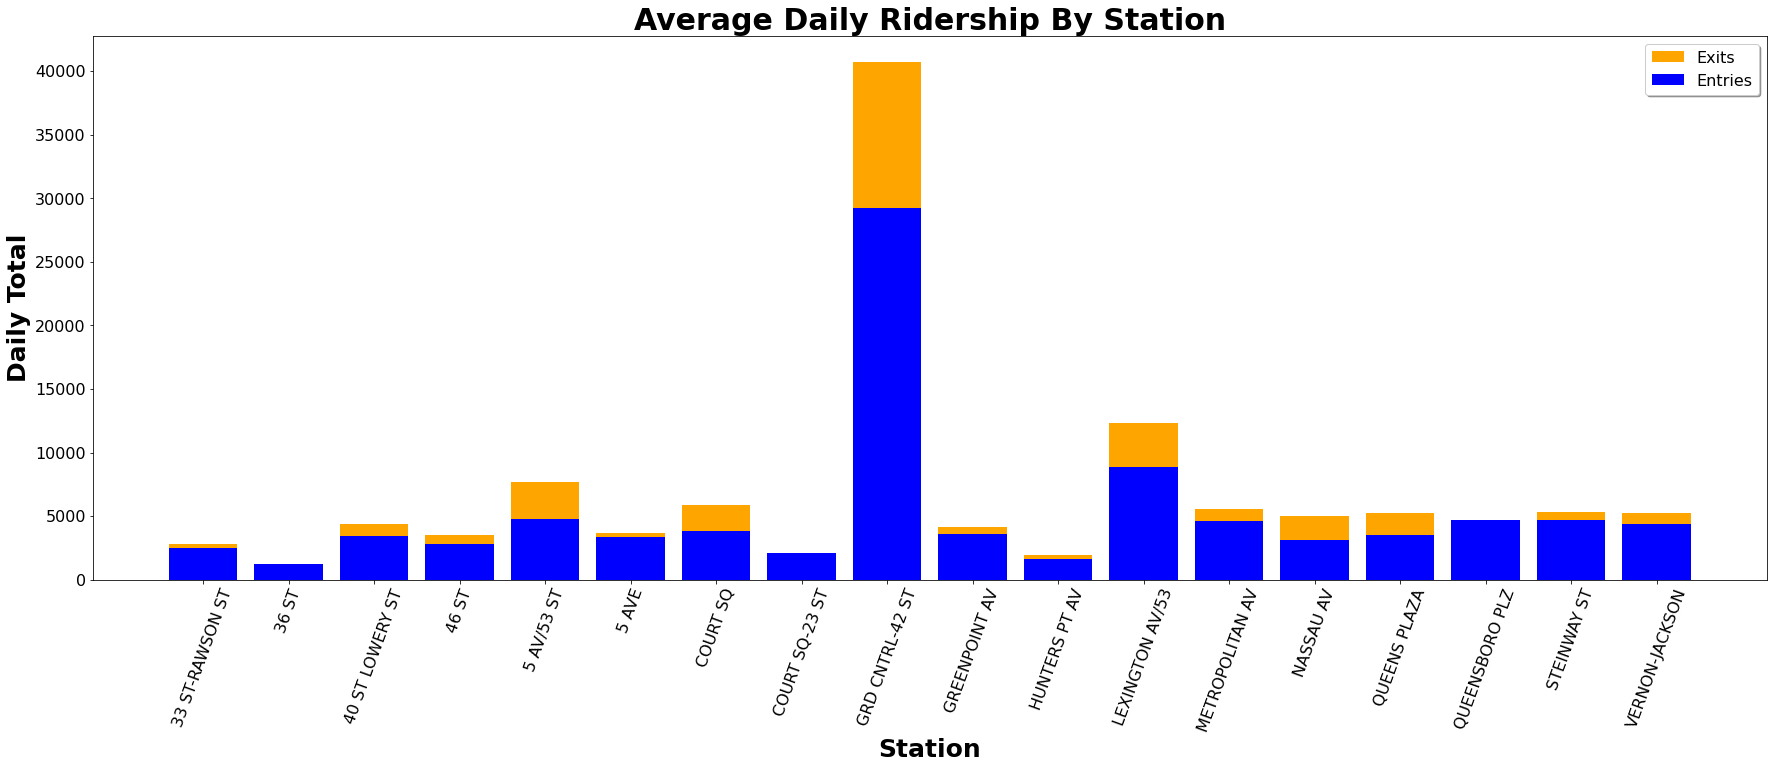

In [21]:
plt.figure(figsize=[30,10])

plt.bar(stations_daily_avg['station'], stations_daily_avg['daily_exits'], color='orange')
plt.xticks(rotation=70, fontsize= 16)
plt.xlabel('Station', fontsize=25, weight ='bold')
plt.ylabel("Daily Total", fontsize=25, weight = 'bold')
plt.yticks( fontsize=16)


plt.bar(stations_daily_avg['station'], stations_daily_avg['daily_entries'], color='b')
plt.title("Average Daily Ridership By Station", fontsize=30, weight="bold")
plt.legend(["Exits", "Entries"], shadow=True, loc=0, fontsize=16)
plt.savefig("Figures/avg_ridership.png")

In [22]:
stations_daily.date = pd.to_datetime(stations_daily.date)
stations_daily["day_week"] =stations_daily.date.dt.dayofweek
stations_daily["week_no"] = stations_daily.date.dt.isocalendar().week
stations_daily["quarter"]= stations_daily.date.dt.month//4 +1

FileNotFoundError: [Errno 2] No such file or directory: 'Figures/week_ridership.png'

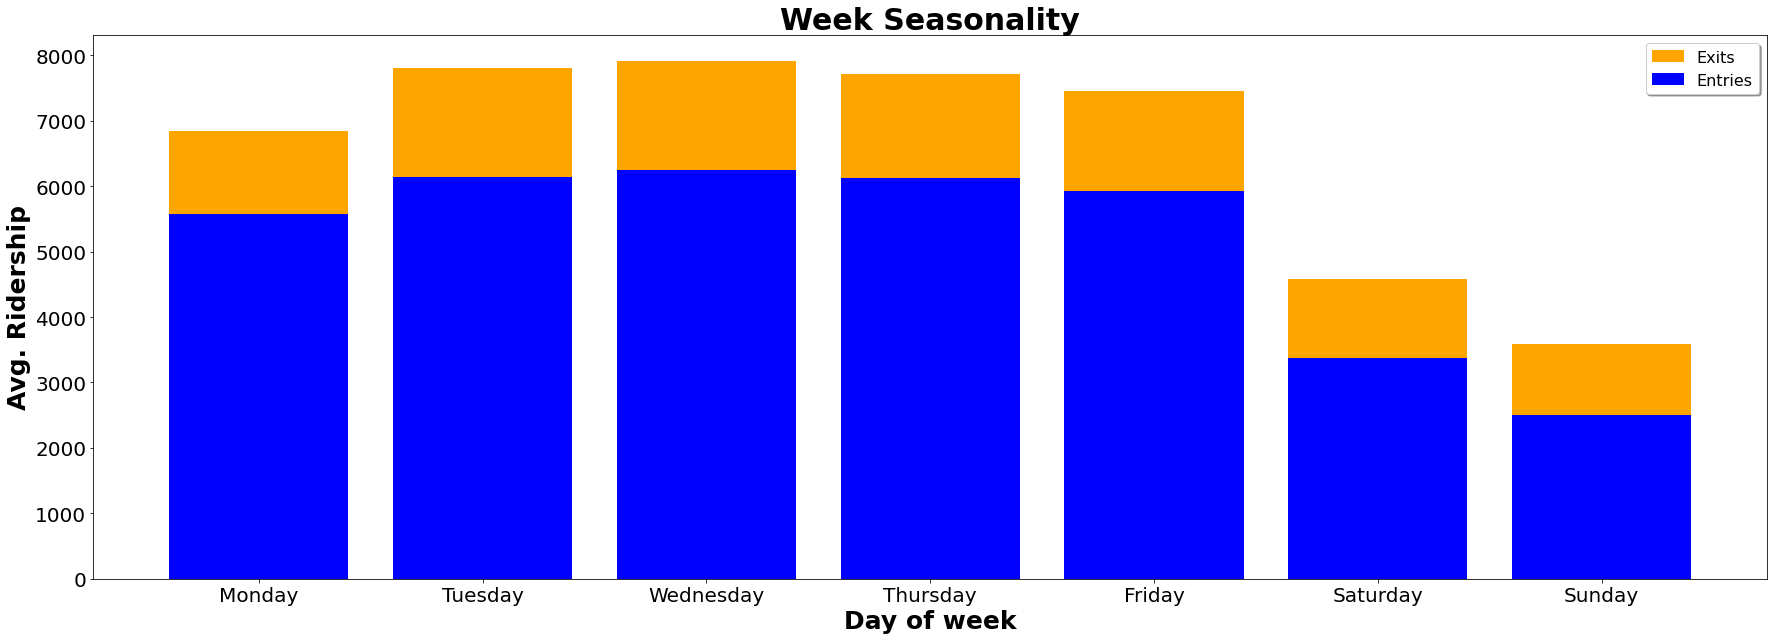

In [23]:
#graphing week seasonality, exits vs. entries
week_season = stations_daily.groupby(['day_week'], as_index=False)[['daily_exits', 'daily_entries']].mean()

plt.figure(figsize=[30, 10])

plt.bar(week_season.day_week, week_season.daily_exits,  color = 'orange', linewidth= 5, linestyle = '-')
plt.xlabel('Day of week', weight= 'bold', fontsize = 25);
plt.ylabel('Avg. Ridership', weight= 'bold', fontsize = 25)
days_of_week= ["Monday", "Tuesday", "Wednesday", "Thursday", 'Friday', 'Saturday', "Sunday"]
plt.xticks(week_season.day_week, days_of_week, fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Exits', fontsize = 30)

plt.bar(week_season.day_week, week_season.daily_entries,  color = 'b', linewidth= 5, linestyle = '-')
plt.title("Week Seasonality", fontsize=30, weight="bold")
plt.legend(["Exits", "Entries"], shadow=True, loc=0, fontsize=16)
plt.savefig("Figures/week_ridership.png")

* looks like Wednesday is the most popular day for travel, weekends are less trafficked reflects effects of pandemic on work schedules.

FileNotFoundError: [Errno 2] No such file or directory: 'Figures/week_by_season.png'

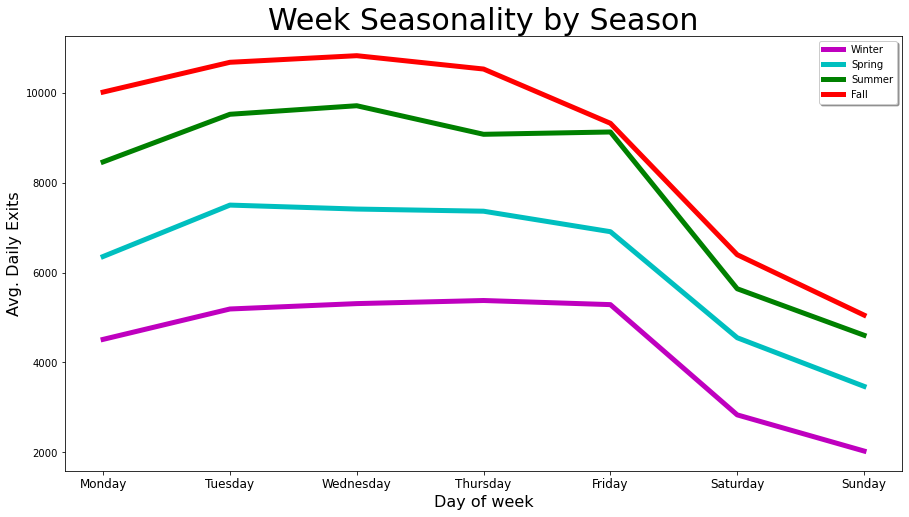

In [24]:
quarter_1= stations_daily[stations_daily["quarter"]==1].groupby(['day_week']).daily_exits.mean()
quarter_2= stations_daily[stations_daily["quarter"]==2].groupby(['day_week']).daily_exits.mean()
quarter_3 = stations_daily[stations_daily["quarter"]==3].groupby(['day_week']).daily_exits.mean()
quarter_4 =stations_daily[stations_daily["quarter"]==4].groupby(['day_week']).daily_exits.mean()

plt.figure(figsize=[15,8])
plt.plot(quarter_1,  linewidth= 5, c= 'm', linestyle = '-')
plt.plot(quarter_2, linewidth= 5, c='c', linestyle = '-')
plt.plot(quarter_3,  linewidth= 5, c='g', linestyle = '-')
plt.plot(quarter_4,  linewidth= 5, c= 'r', linestyle = '-')

plt.xlabel('Day of week', size= 16);
plt.ylabel('Avg. Daily Exits', size= 16)
plt.xticks(week_season.day_week, days_of_week, fontsize = 12)
plt.title('Week Seasonality by Season', size= 30)
plt.legend(["Winter", "Spring", "Summer", "Fall"],  shadow= True, loc =0)
plt.savefig("Figures/week_by_season.png")

In [25]:
stations_avg_nogrand=stations_daily_avg[
    stations_daily_avg.station != "GRD CNTRL-42 ST"].copy()
stations_avg_nogrand["total_traffic"]= stations_avg_nogrand.daily_exits + stations_avg_nogrand.daily_entries

stations_avg_nogrand["quartile"]=pd.qcut(
    stations_avg_nogrand.total_traffic, q=4, labels=[1,2,3,4])
quartiles=stations_avg_nogrand.loc[:, ["station", "quartile"]]

In [26]:
stations_daily_nogrand= stations_daily[stations_daily.station != "GRD CNTRL-42 ST"].copy()
stations_daily_nogrand = pd.merge(stations_daily_nogrand, quartiles, on = "station", how= 'left')


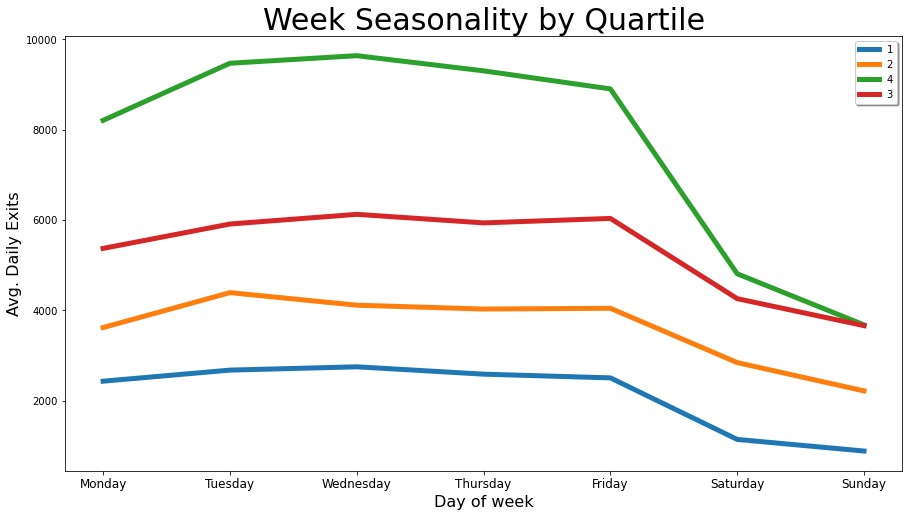

In [35]:

for i in [1, 2, 3, 4]:
    exec(f"q{i}_weekly_avg= stations_daily_nogrand[stations_daily_nogrand.quartile == i].groupby(['day_week']).daily_exits.mean()")


legend=[]
plt.figure(figsize=[15,8])
for i in stations_avg_nogrand.quartile.unique():
        
        exec(f'(plt.plot(q{i}_weekly_avg, linewidth= 5))')
        plt.xlabel('Day of week',fontsize=16);
        plt.ylabel('Avg. Daily Exits', fontsize=16)
        plt.xticks(week_season.day_week, days_of_week, fontsize = 12)
        plt.title('Week Seasonality by Quartile', fontsize=30)
        legend.append(i)
       

plt.legend(legend, shadow = True, loc = 0)
plt.savefig("Figures/week_by_quartile.png")

# Time Series for Highly Trafficked Stations in Each Borough

In [36]:
station_names= ["COURT SQ", "COURT SQ-23 ST", "HUNTERS PT AV", "VERNON-JACKSON",
                "QUEENSBORO PLZ", "QUEENS PLAZA", "33 ST-RAWSON ST", "40 ST LOWERY ST",
                "36 ST", "STEINWAY ST", "46 ST", "GREENPOINT AV", "NASSAU AV","METROPOLITAN AV",
                "5 AVE", "GRD CNTRL-42 ST", "LEXINGTON AV/53", "5 AV/53 ST", ]
boroughs = ["Q","Q","Q","Q","Q","Q","Q","Q","Q","Q","Q", "BK","BK","BK","M", "M", "M", "M"]

columns = ["station", "borough"]

station_borough= list(zip(station_names, boroughs))
boro_df = pd.DataFrame(station_borough, columns=columns)
borough_daily = pd.merge(stations_daily, boro_df, on="station", how='left')

In [37]:
avg_by_borough = borough_daily.groupby(
    ["borough", "station"], as_index=False)[
    ["daily_exits", "daily_entries"]].mean().sort_values(
    ["borough", "daily_exits"], ascending = [True, False])
avg_by_borough["total"]=avg_by_borough.daily_entries + avg_by_borough.daily_exits
avg_by_borough.sort_values(["borough", "total"], ascending=[True, False])

,borough,station,daily_exits,daily_entries,total
1,BK,METROPOLITAN AV,5574.050420,4630.467787,10204.518207
2,BK,NASSAU AV,4974.224090,3135.355742,8109.579832
0,BK,GREENPOINT AV,4128.927171,3597.658263,7726.585434
5,M,GRD CNTRL-42 ST,40735.523810,29238.806723,69974.330532
6,M,LEXINGTON AV/53,12316.753501,8844.621849,21161.375350
3,M,5 AV/53 ST,7668.630252,4770.484594,12439.114846
4,M,5 AVE,3699.462185,3318.134454,7017.596639
16,Q,STEINWAY ST,5301.313725,4666.722689,9968.036415
11,Q,COURT SQ,5838.274510,3842.649860,9680.924370
17,Q,VERNON-JACKSON,5256.058824,4407.504202,9663.563025


* Top Stations by borough: Metropolitan, Grand Central, Steinway St, Vernon-Jackson. I include two from Queens because most of the stations in the dataset are in Queens. Since Grand Central is a major commuter connection station, exits may not be a strong measure of the number of commuters exiting the train station and walking directly home. Instead, a great deal of commuters may exit the MTA and then transfer to Bus or Rail. So, we'll look at Lexington Ave and 53rd st.

* Smaller, local stations may also be of interest-- if the station is smaller, and is not close ot major bus lines, their exit numbers are likely to better respresent the real numbers of commuters exiting the MTA to go directly home. So, we'll look also at 5 AV, Greenpoint AV, 40th St-Lowery ST, and 36 ST.


##  Court Sq

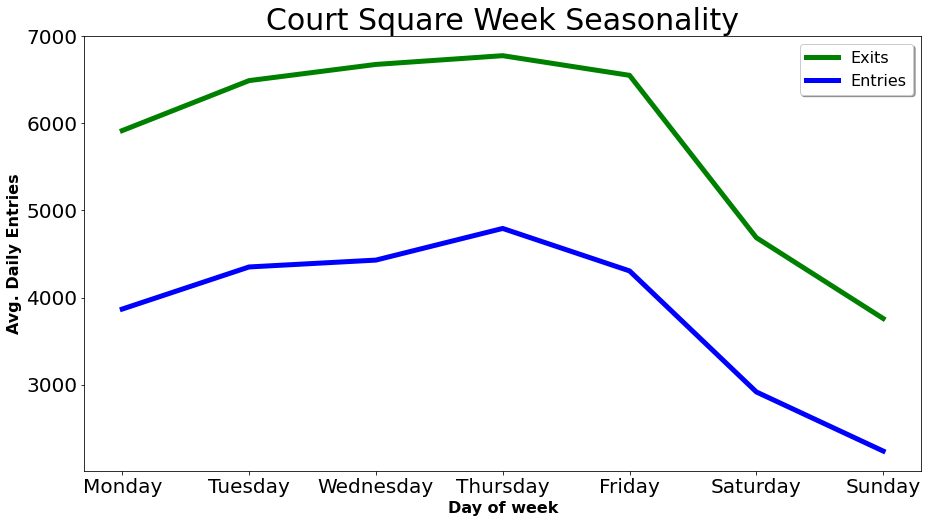

In [38]:
week_season_station = stations_daily.groupby(['station','day_week'], as_index=False)[['daily_exits', 'daily_entries']].mean()
week_season_station.replace(to_replace="COURT SQ-23 ST", value="COURT SQ", inplace=True)
week_season_station = stations_daily.groupby(['station','day_week'], as_index=False)[['daily_exits', 'daily_entries']].mean()
court_sq_daily= week_season_station[week_season_station.station=='COURT SQ']

plt.figure(figsize=[15, 8])                                     
plt.plot(court_sq_daily.day_week, court_sq_daily.daily_exits,  color = 'g', linewidth= 5, linestyle = '-')
plt.plot(court_sq_daily.day_week, court_sq_daily.daily_entries,  color = 'b', linewidth= 5, linestyle = '-')
plt.xlabel('Day of week', fontsize = 16, weight="bold");
plt.ylabel('Avg. Daily Entries', fontsize = 16, weight="bold")
days_of_week= ["Monday", "Tuesday", "Wednesday", "Thursday", 'Friday', 'Saturday', "Sunday"]
plt.xticks(week_season.day_week, days_of_week, fontsize = 20)
plt.yticks(fontsize = 20)
plt.title("Court Square Week Seasonality", fontsize = 30)
plt.legend(["Exits", "Entries"], shadow=True, loc=0, fontsize=16)
plt.savefig("Figures/courtsq_week.png")

In [39]:
tstiles_day=full_df.groupby([
    "ca", "unit", "scp", "station", "linename", "date_time"], as_index=False)[['entries', 'exits']].first()
tstiles_day['delta_exits']=abs(tstiles_day.exits.diff(1))
tstiles_day['delta_entries']=abs(tstiles_day.entries.diff(1))
tstiles_day = tstiles_day.groupby(["station", "date_time"], as_index=False)[['delta_exits', 'delta_entries']].sum()


tstiles_day["hour"]=tstiles_day.date_time.dt.hour
tstiles_day["day_week"]=tstiles_day.date_time.dt.weekday

tstiles_day.dropna(subset=['delta_exits', 'delta_entries'], inplace=True)
tstiles_day["date"]=tstiles_day.date_time.dt.date
tstiles_day.drop(tstiles_day[tstiles_day.date== datetime.date(2021, 1, 1)].index, inplace=True)

tstiles_courtsq = tstiles_day.replace(to_replace="COURT SQ-23 ST", value="COURT SQ")
tstiles_courtsq = tstiles_courtsq[tstiles_courtsq.station == "COURT SQ"]

week_hr_court_sq = tstiles_courtsq.groupby(["day_week", "hour"], as_index=False)[["delta_entries", "delta_exits"]].mean()

avg_hourly_courtsq = tstiles_courtsq.groupby("hour")[["delta_entries", "delta_exits"]].mean()


In [40]:
tstiles_courtsq.sort_values("delta_exits", ascending = False).head(40)

,station,date_time,delta_exits,delta_entries,hour,day_week,date
14420,COURT SQ,2021-08-30 16:00:00,1058164.0,2031208.0,16,0,2021-08-30
15381,COURT SQ,2021-02-13 11:00:00,132089.0,2552513.0,11,5,2021-02-13
15384,COURT SQ,2021-02-13 15:00:00,91807.0,101358.0,15,5,2021-02-13
13182,COURT SQ,2021-02-11 15:00:00,7733.0,20905.0,15,3,2021-02-11
13998,COURT SQ,2021-06-21 16:00:00,7226.0,920.0,16,0,2021-06-21
15405,COURT SQ,2021-02-14 15:00:00,5787.0,6437.0,15,6,2021-02-14
14105,COURT SQ,2021-07-09 09:36:46,4787.0,161.0,9,4,2021-07-09
14889,COURT SQ,2021-11-16 11:00:00,3594.0,1270.0,11,1,2021-11-16
14895,COURT SQ,2021-11-17 11:00:00,3528.0,1277.0,11,2,2021-11-17
15021,COURT SQ,2021-12-08 11:00:00,3507.0,1220.0,11,2,2021-12-08


In [41]:
#something strange is happening on 2/13/2021 and 8/30/2021

tstiles_courtsq[(tstiles_courtsq.date==datetime.date(2021, 2, 13) )|
               (tstiles_courtsq.date==datetime.date(2021, 8, 30))].head(1000)                                                  

,station,date_time,delta_exits,delta_entries,hour,day_week,date
13191,COURT SQ,2021-02-13 03:00:00,153.0,75.0,3,5,2021-02-13
13192,COURT SQ,2021-02-13 07:00:00,225.0,96.0,7,5,2021-02-13
13193,COURT SQ,2021-02-13 11:00:00,629.0,357.0,11,5,2021-02-13
13194,COURT SQ,2021-02-13 15:00:00,715.0,653.0,15,5,2021-02-13
13195,COURT SQ,2021-02-13 19:00:00,789.0,724.0,19,5,2021-02-13
13196,COURT SQ,2021-02-13 23:00:00,424.0,327.0,23,5,2021-02-13
14416,COURT SQ,2021-08-30 00:00:00,917.0,374.0,0,0,2021-08-30
14417,COURT SQ,2021-08-30 04:00:00,137.0,87.0,4,0,2021-08-30
14418,COURT SQ,2021-08-30 08:00:00,1052.0,365.0,8,0,2021-08-30
14419,COURT SQ,2021-08-30 12:00:00,1557.0,834.0,12,0,2021-08-30


In [42]:
# let's remove outliers from the data
tstiles_courtsq['delta_exits'] = tstiles_courtsq[
    'delta_exits'].apply(lambda x: -50 if x > 10000 else x).astype(int)
tstiles_courtsq['delta_entries'] = tstiles_courtsq[
    'delta_entries'].apply(lambda x: -50 if x > 10000 else x).astype(int)

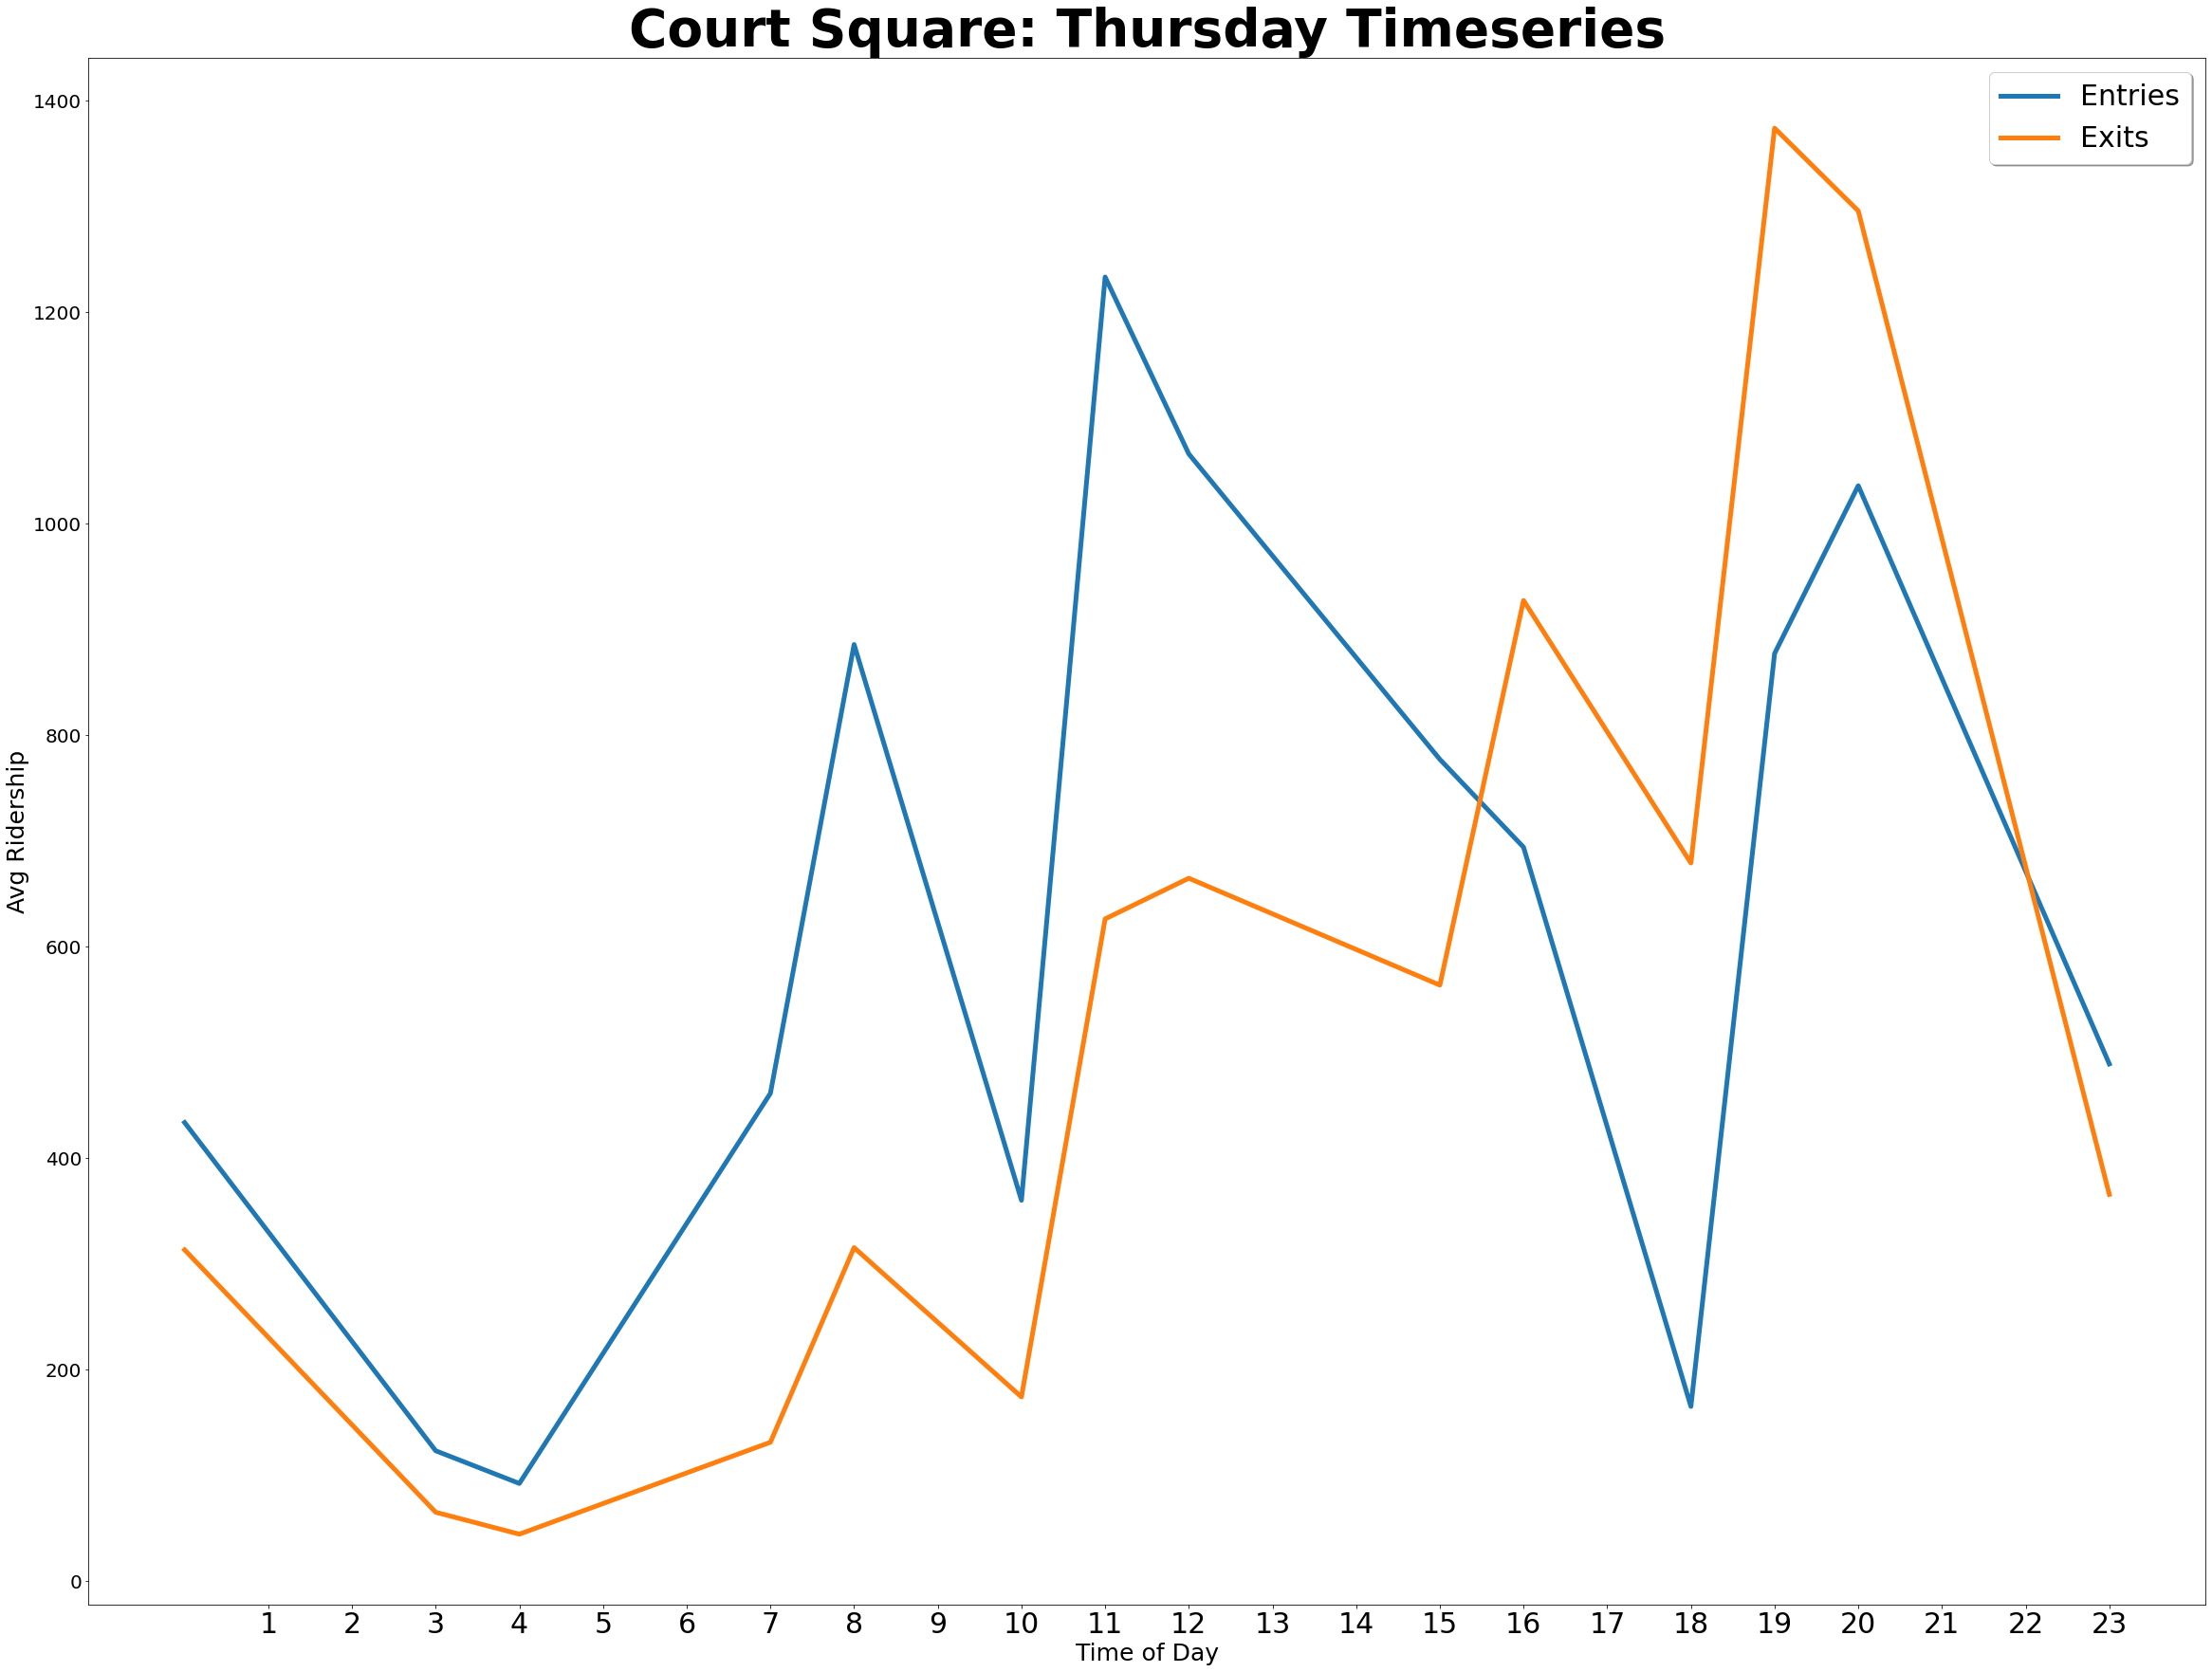

In [43]:

hourly_courtsq = tstiles_courtsq.groupby([
    "day_week","hour"], as_index=False)[['delta_exits', 'delta_entries']].mean()

thurs_courtsq = hourly_courtsq[hourly_courtsq.day_week==3].groupby(
    "hour")[['delta_exits', 'delta_entries']].mean()

plt.figure(figsize=[40,30]) 
plt.plot(thurs_courtsq, linewidth= 5, linestyle = '-')
plt.xlabel('Time of Day', fontsize = 25);
plt.ylabel('Avg Ridership', fontsize = 25)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22 ,23], fontsize = 30)
plt.yticks(fontsize = 20)
plt.title('Court Square: Thursday Timeseries', fontsize = 55, weight = 'bold')
plt.legend(["Entries", "Exits"], shadow=True, loc= 0, fontsize = 30)
plt.savefig("Figures/courtsq_thurs.png")


* The figure shows that from 3pm to 10 pm, more people are entering than exiting Court Square, suggesting people are beginning their homebound commute for the day. This window is an optimal window for a late-night.

## Vernon-Jackson

In [44]:
tstiles_vjack = tstiles_day[tstiles_day.station == "VERNON-JACKSON"].copy()
tstiles_vjack.sort_values(["delta_entries", "delta_exits"], 
                           ascending = [False, False]).head(45)


,station,date_time,delta_exits,delta_entries,hour,day_week,date
43249,VERNON-JACKSON,2021-12-15 11:00:00,2034.0,5900427.0,11,2,2021-12-15
43250,VERNON-JACKSON,2021-12-15 15:00:00,1163.0,5899137.0,15,2,2021-12-15
42835,VERNON-JACKSON,2021-10-07 16:00:00,7767773.0,4027960.0,16,3,2021-10-07
43081,VERNON-JACKSON,2021-11-17 11:00:00,1970.0,2458.0,11,2,2021-11-17
43039,VERNON-JACKSON,2021-11-10 11:00:00,1982.0,2423.0,11,2,2021-11-10
43075,VERNON-JACKSON,2021-11-16 11:00:00,1927.0,2408.0,11,1,2021-11-16
42263,VERNON-JACKSON,2021-07-05 00:00:00,5442.0,2406.0,0,0,2021-07-05
43201,VERNON-JACKSON,2021-12-07 11:00:00,1945.0,2390.0,11,1,2021-12-07
43207,VERNON-JACKSON,2021-12-08 11:00:00,2043.0,2377.0,11,2,2021-12-08
43033,VERNON-JACKSON,2021-11-09 11:00:00,1914.0,2376.0,11,1,2021-11-09


In [45]:
#misreporting on 10/17/2021

In [46]:

tstiles_vjack['delta_exits'] = tstiles_vjack['delta_exits'].apply(
    lambda x: -50 if x > 10000 else x).astype(int)
tstiles_vjack['delta_entries'] = tstiles_vjack['delta_entries'].apply(
    lambda x: -50 if x > 10000 else x).astype(int)

hourly_vjack = tstiles_vjack.groupby(["day_week","hour"], as_index=False)[['delta_exits', 'delta_entries']].mean()

avg_hourly_vjack = hourly_vjack.groupby("hour")[["delta_entries", "delta_exits"]].mean()
avg_hourly_vjack.sort_values(["delta_entries", "delta_exits"], ascending = [False, False])
hourly_vjack.sort_values(["delta_entries", "delta_exits"], ascending = [False, False])




,day_week,hour,delta_exits,delta_entries
35,2,19,1754.647059,1720.882353
23,1,19,1748.470588,1695.529412
62,4,20,2088.088235,1654.441176
49,3,19,1642.823529,1620.352941
50,3,20,2116.676471,1601.029412
...,...,...,...,...
41,3,4,75.411765,38.176471
67,5,7,85.000000,32.941176
28,2,4,65.705882,32.000000
15,1,4,60.500000,31.882353


In [47]:
# looks like the counter is reset at midnight on Thursdays, and a misreporting error on 11/10/2021 at noon.

In [48]:
tstiles_vjack.sort_values(["delta_entries", "delta_exits"], 
                           ascending = [False, False]).head(45)
vjack_thurs=hourly_vjack[hourly_vjack.day_week==3].groupby("hour")[["delta_entries", "delta_exits"]].mean()
vjack_thurs

,delta_entries,delta_exits
hour,,
0,504.617647,794.558824
3,71.294118,128.352941
4,38.176471,75.411765
7,220.647059,545.470588
8,660.529412,1084.852941
10,156.000000,357.000000
11,1358.941176,1242.058824
12,1435.323529,1201.735294
15,921.882353,895.705882


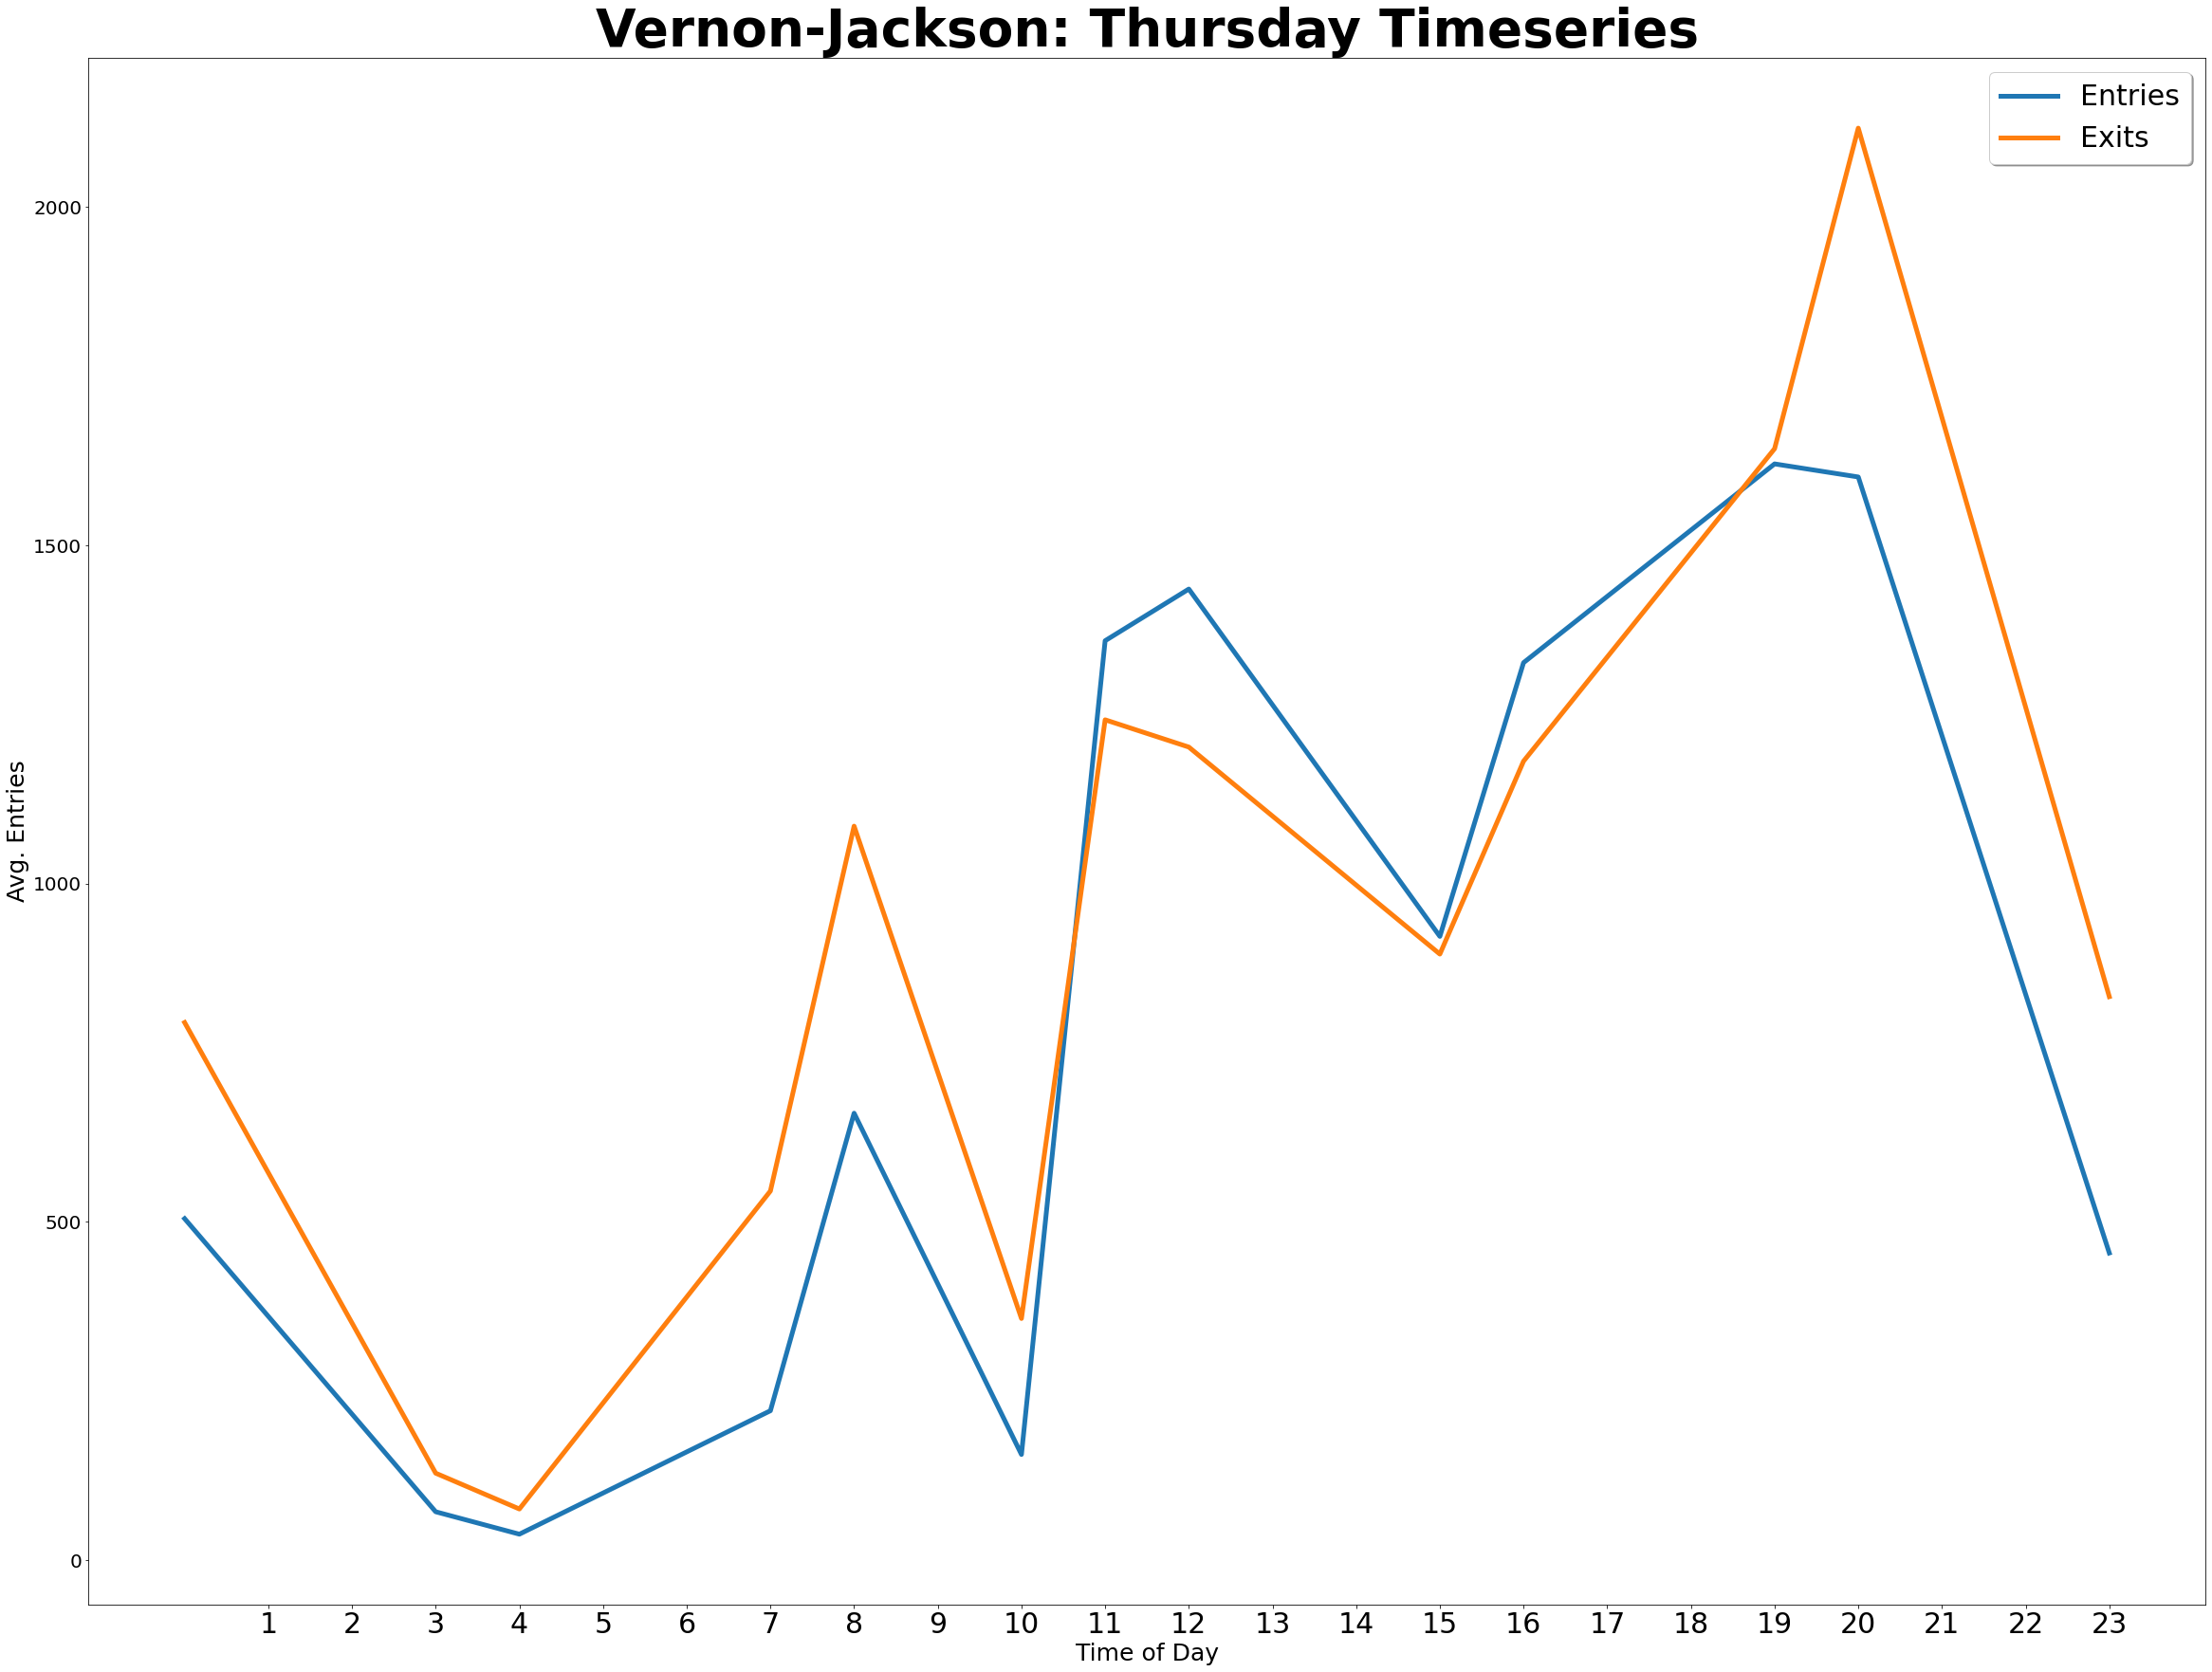

In [49]:

plt.figure(figsize=[40,30]) 


plt.plot(vjack_thurs, linewidth= 5, linestyle = '-')

plt.xlabel('Time of Day', fontsize = 25);
plt.ylabel('Avg. Entries', fontsize = 25)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22 ,23], fontsize = 30)
plt.yticks(fontsize = 20)
plt.title('Vernon-Jackson: Thursday Timeseries', fontsize = 55, weight = 'bold')
plt.legend(["Entries", "Exits"], shadow=True, loc= 0, fontsize = 30)
plt.savefig("Figures/vernon_jackson_thurs.png")

In [50]:
vjack_thurs

,delta_entries,delta_exits
hour,,
0,504.617647,794.558824
3,71.294118,128.352941
4,38.176471,75.411765
7,220.647059,545.470588
8,660.529412,1084.852941
10,156.000000,357.000000
11,1358.941176,1242.058824
12,1435.323529,1201.735294
15,921.882353,895.705882


# Steinway St

In [53]:
tstiles_stnwy = tstiles_day[tstiles_day.station == "STEINWAY ST"].copy()

hourly_stnwy  = tstiles_stnwy.groupby("hour")[["delta_entries", "delta_exits"]].mean()


tstiles_stnwy.sort_values(["delta_entries", "delta_exits"], 
                           ascending = [False, False]).head(45)



,station,date_time,delta_exits,delta_entries,hour,day_week,date
40881,STEINWAY ST,2021-11-17 11:00:00,1600.0,2296.0,11,2,2021-11-17
40839,STEINWAY ST,2021-11-10 11:00:00,1652.0,2281.0,11,2,2021-11-10
41001,STEINWAY ST,2021-12-07 11:00:00,1600.0,2279.0,11,1,2021-12-07
40875,STEINWAY ST,2021-11-16 11:00:00,1586.0,2241.0,11,1,2021-11-16
39878,STEINWAY ST,2021-06-03 16:00:00,2208.0,2233.0,16,3,2021-06-03
40887,STEINWAY ST,2021-11-18 11:00:00,1614.0,2220.0,11,3,2021-11-18
40971,STEINWAY ST,2021-12-02 11:00:00,1580.0,2220.0,11,3,2021-12-02
41007,STEINWAY ST,2021-12-08 11:00:00,1515.0,2207.0,11,2,2021-12-08
40959,STEINWAY ST,2021-11-30 11:00:00,1642.0,2196.0,11,1,2021-11-30
40965,STEINWAY ST,2021-12-01 11:00:00,1583.0,2190.0,11,2,2021-12-01


In [54]:
tstiles_stnwy['daily_exits'] = tstiles_stnwy['delta_exits'].apply(
    lambda x: -50 if x > 10000 else x).astype(int)
tstiles_stnwy['daily_entries'] = tstiles_stnwy['delta_entries'].apply(
    lambda x: -50 if x > 10000 else x).astype(int)

In [55]:
hourly_stnwy = tstiles_stnwy.groupby(["day_week","hour"], as_index=False)[['delta_exits', 'delta_entries']].mean()

avg_hourly_stnwy = hourly_stnwy.groupby("hour")[["delta_entries", "delta_exits"]].mean()

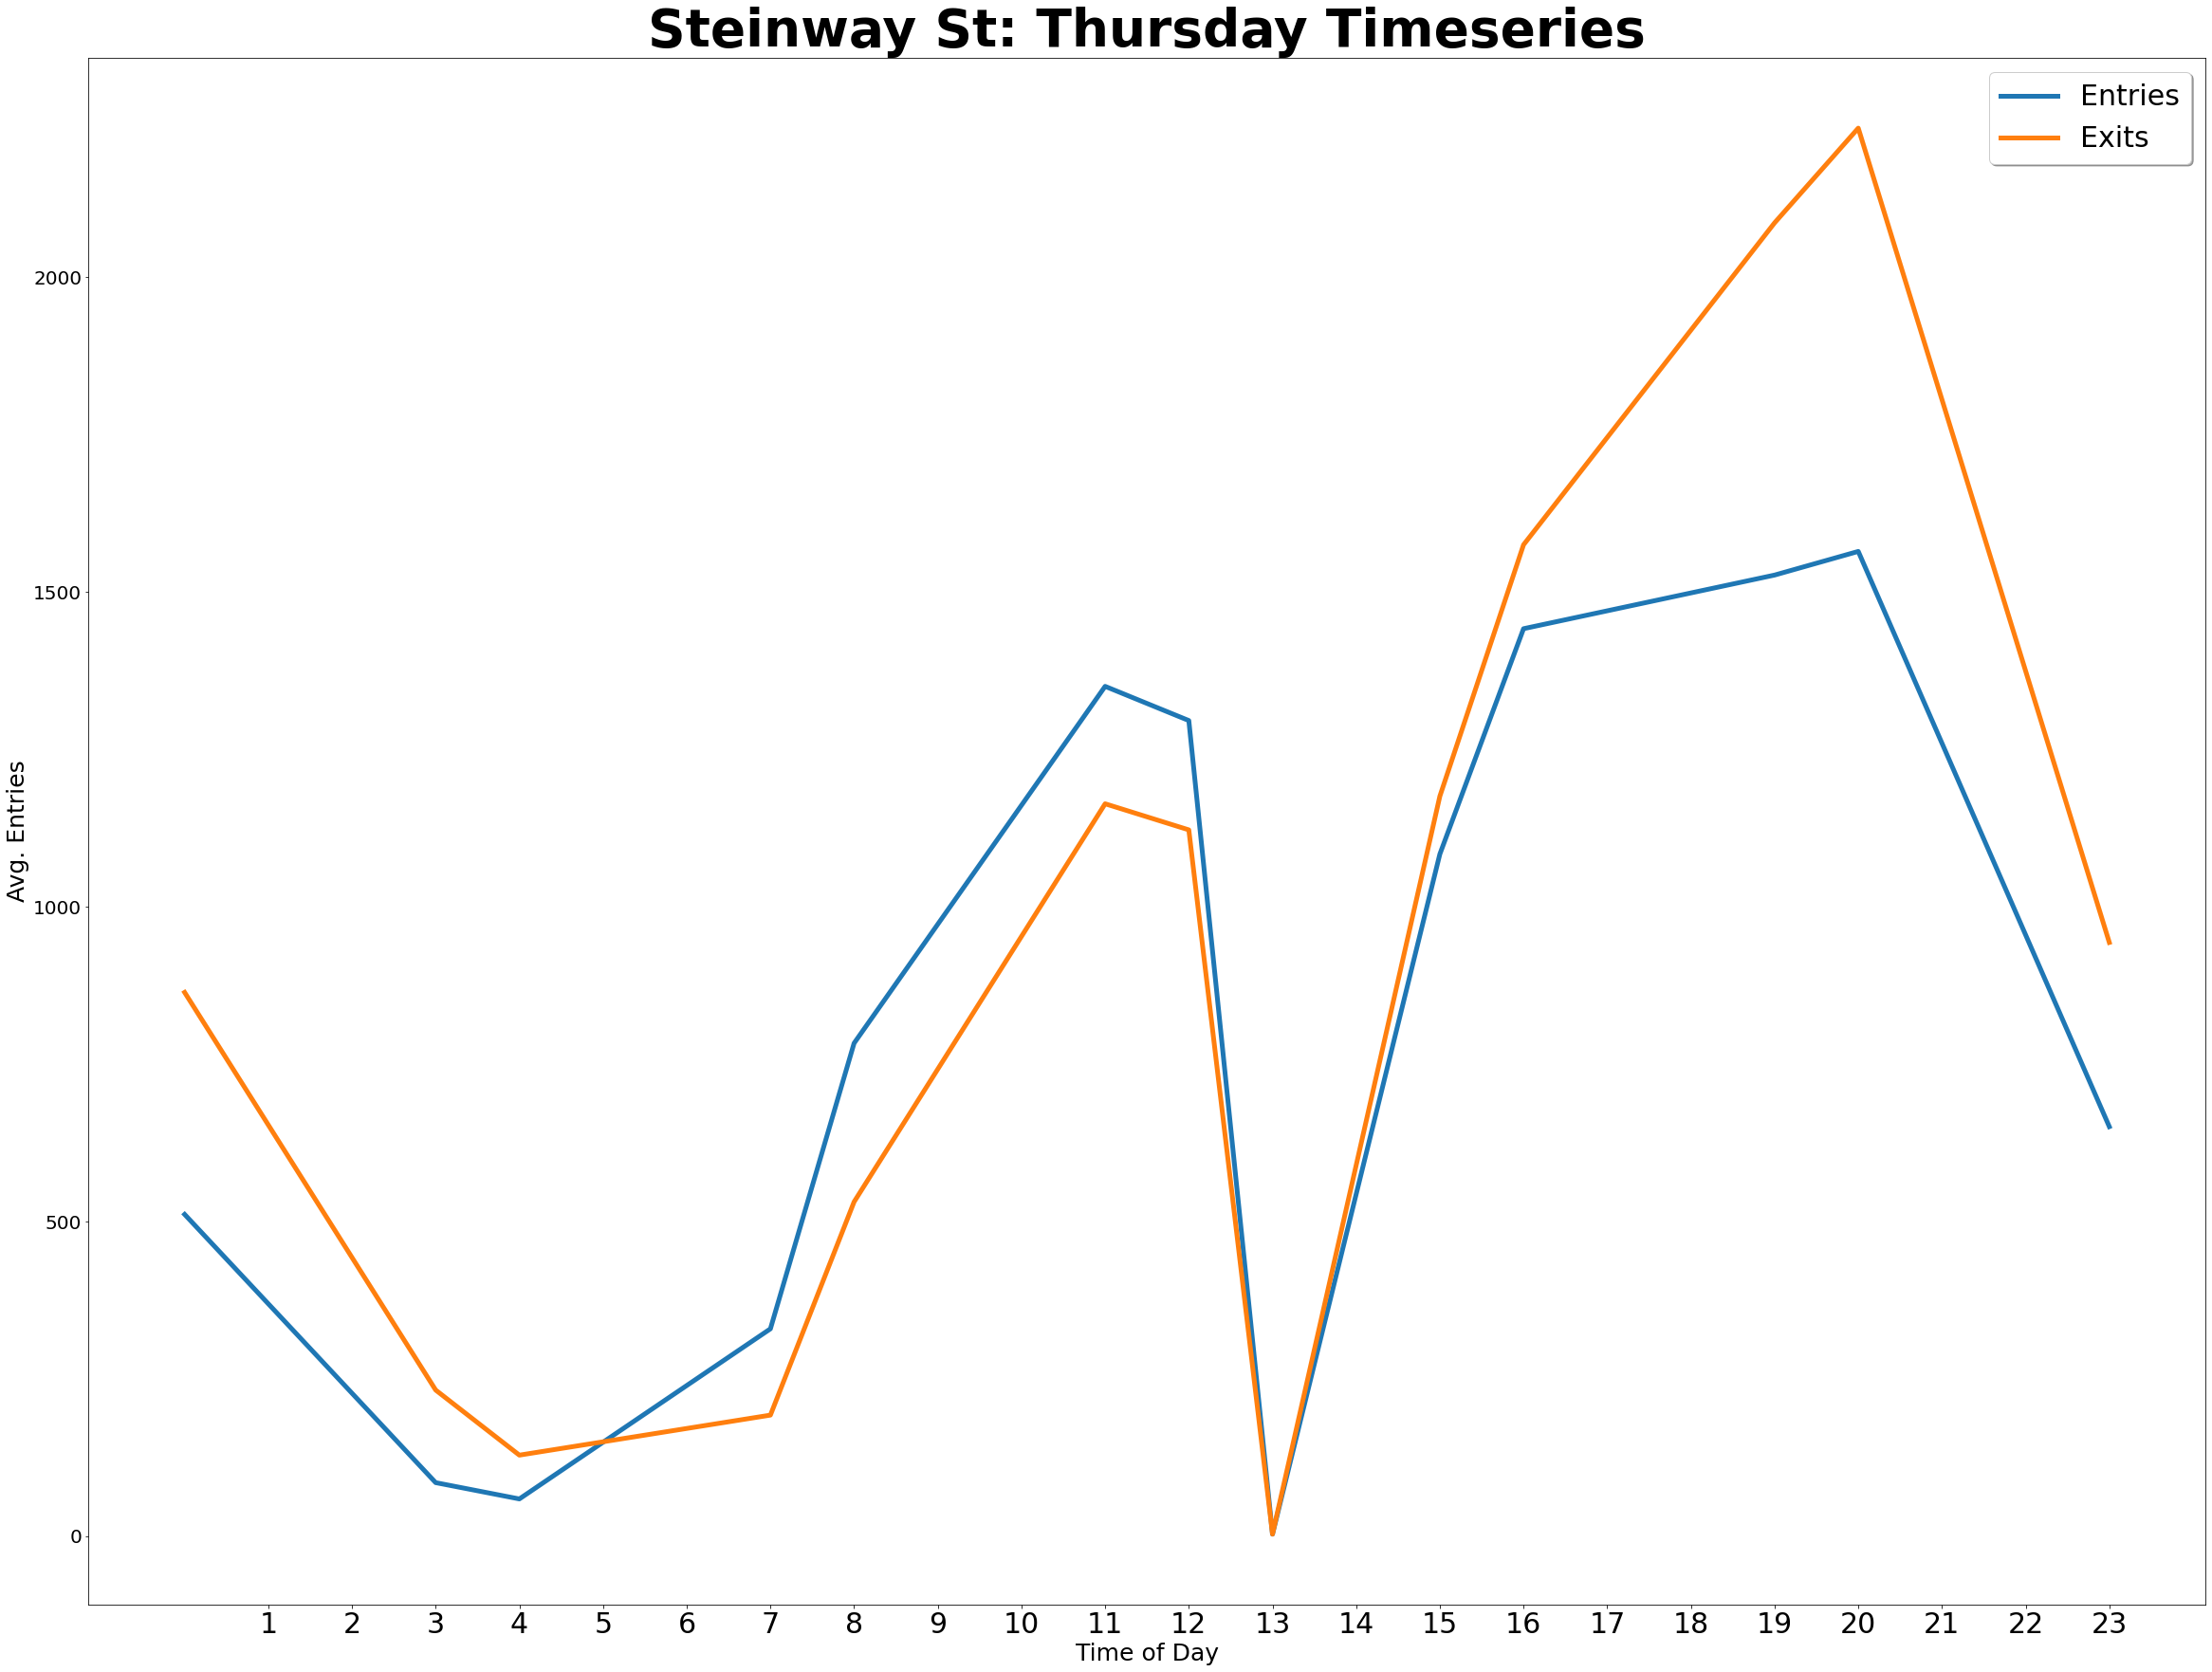

In [56]:
stnwy_thurs=hourly_stnwy[hourly_stnwy.day_week==4].groupby("hour")[["delta_entries", "delta_exits"]].mean()
plt.figure(figsize=[40,30]) 


plt.plot(stnwy_thurs, linewidth= 5, linestyle = '-')

plt.xlabel('Time of Day', fontsize = 25);
plt.ylabel('Avg. Entries', fontsize = 25)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22 ,23], fontsize = 30)
plt.yticks(fontsize = 20)
plt.title('Steinway St: Thursday Timeseries', fontsize = 55, weight = 'bold')
plt.legend(["Entries", "Exits"], shadow=True, loc= 0, fontsize = 30)
plt.savefig("Figures/steinway_thurs.png")

In [57]:
stnwy_thurs.sort_values("delta_exits", ascending=False)

,delta_entries,delta_exits
hour,,
20,1564.588235,2237.147059
19,1527.000000,2086.705882
16,1441.794118,1575.147059
15,1083.647059,1175.588235
11,1350.176471,1163.588235
12,1295.864865,1122.135135
23,650.529412,943.235294
0,511.147059,863.882353
8,783.147059,531.058824


# Metropolitan Ave

In [58]:
tstiles_metrop= tstiles_day[tstiles_day.station == "METROPOLITAN AV"].copy()


,day_week,hour,delta_exits,delta_entries
86,4,17,35396.0,34086.0
89,4,21,53624.0,32928.0
104,5,17,44451.0,32889.0
107,5,21,48207.0,30703.0
50,2,17,29332.0,29981.0
68,3,17,29205.0,29572.0
71,3,21,45125.0,29523.0
53,2,21,42510.0,29174.0
32,1,17,28146.0,29084.0
88,4,20,45671.0,28605.0


In [59]:
tstiles_metrop.sort_values(["delta_entries", "delta_exits"], 
                           ascending = [False, False]).head(45)

,station,date_time,delta_exits,delta_entries,hour,day_week,date
31226,METROPOLITAN AV,2021-09-12 17:00:00,2814.0,2989.0,17,6,2021-09-12
30389,METROPOLITAN AV,2021-07-05 01:00:00,1073.0,1993.0,1,0,2021-07-05
32025,METROPOLITAN AV,2021-11-17 15:00:00,1235.0,1485.0,15,2,2021-11-17
31370,METROPOLITAN AV,2021-09-24 17:00:00,1145.0,1327.0,17,4,2021-09-24
31799,METROPOLITAN AV,2021-10-29 17:00:00,1362.0,1294.0,17,4,2021-10-29
31631,METROPOLITAN AV,2021-10-15 17:00:00,1263.0,1254.0,17,4,2021-10-15
31539,METROPOLITAN AV,2021-10-08 17:00:00,1185.0,1253.0,17,4,2021-10-08
31382,METROPOLITAN AV,2021-09-25 17:00:00,1659.0,1243.0,17,5,2021-09-25
32052,METROPOLITAN AV,2021-11-19 20:00:00,1976.0,1223.0,20,4,2021-11-19
31715,METROPOLITAN AV,2021-10-22 17:00:00,1244.0,1222.0,17,4,2021-10-22


In [73]:
hourly_metrop = tstiles_metrop.groupby(
    ["day_week","hour"], as_index=False)[
    ['delta_exits', 'delta_entries']].mean()

avg_hourly_metrop = hourly_metrop.groupby(
    "hour")[["delta_entries", "delta_exits"]].mean()
hourly_metrop.sort_values(["delta_entries", "delta_exits"], 
                           ascending = [False, False]).head(45)
tstiles_metrop['delta_exits'] = tstiles_metrop['delta_exits'].apply(
    lambda x: -50 if x > 10000 else x).astype(int)
tstiles_metrop['delta_entries'] = tstiles_metrop['delta_entries'].apply(
    lambda x: -50 if x > 10000 else x).astype(int)

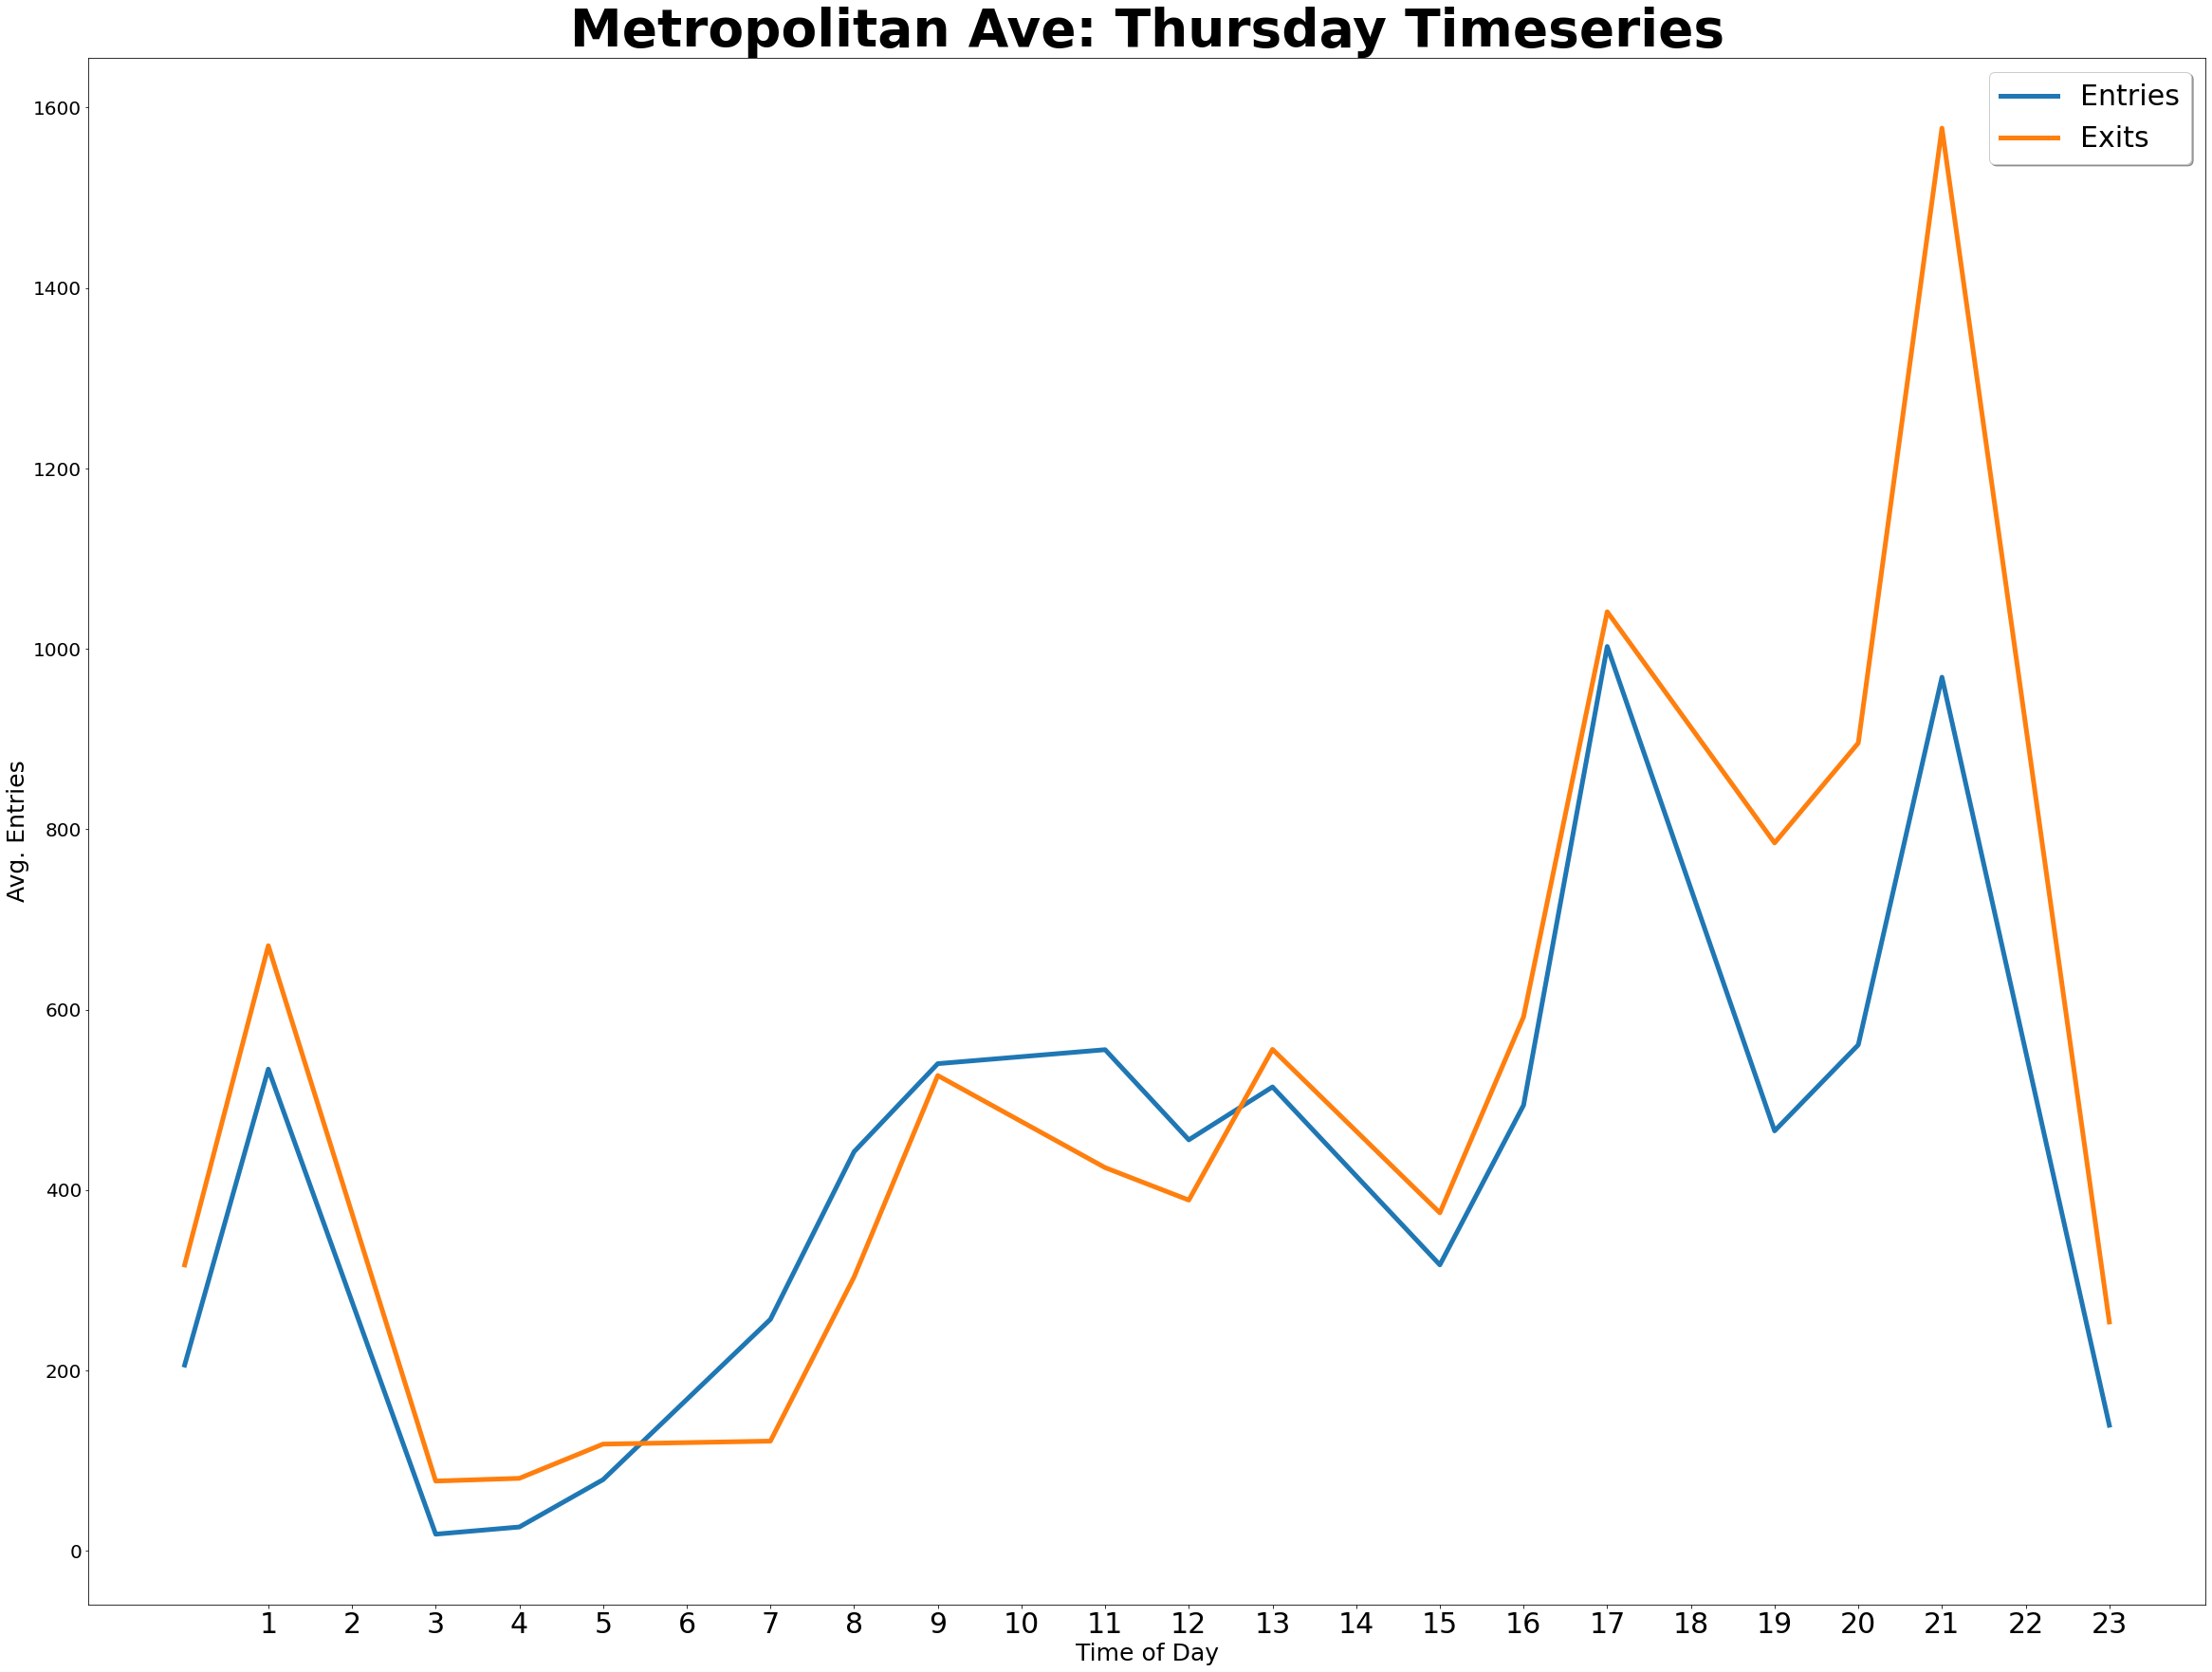

In [74]:
metrop_thurs=hourly_metrop[hourly_metrop.day_week==4].groupby("hour")[["delta_entries", "delta_exits"]].mean()
plt.figure(figsize=[40,30]) 


plt.plot(metrop_thurs, linewidth= 5, linestyle = '-')

plt.xlabel('Time of Day', fontsize = 25);
plt.ylabel('Avg. Entries', fontsize = 25)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22 ,23], fontsize = 30)
plt.yticks(fontsize = 20)
plt.title('Metropolitan Ave: Thursday Timeseries', fontsize = 55, weight = 'bold')
plt.legend(["Entries", "Exits"], shadow=True, loc= 0, fontsize = 30)
plt.savefig("Figures/metropolitan_av_thurs.png")


# Lexington Ave/53

In [61]:
tstiles_lx53 = tstiles_day[tstiles_day.station == "LEXINGTON AV/53"].copy()
tstiles_lx53.sort_values(["delta_entries", "delta_exits"], 
                           ascending = [False, False]).head(45)

tstiles_lx53['delta_exits'] = tstiles_lx53['delta_exits'].apply(
    lambda x: -50 if x > 10000 else x).astype(int)
tstiles_lx53['delta_entries'] = tstiles_lx53['delta_entries'].apply(
    lambda x: -50 if x > 10000 else x).astype(int)

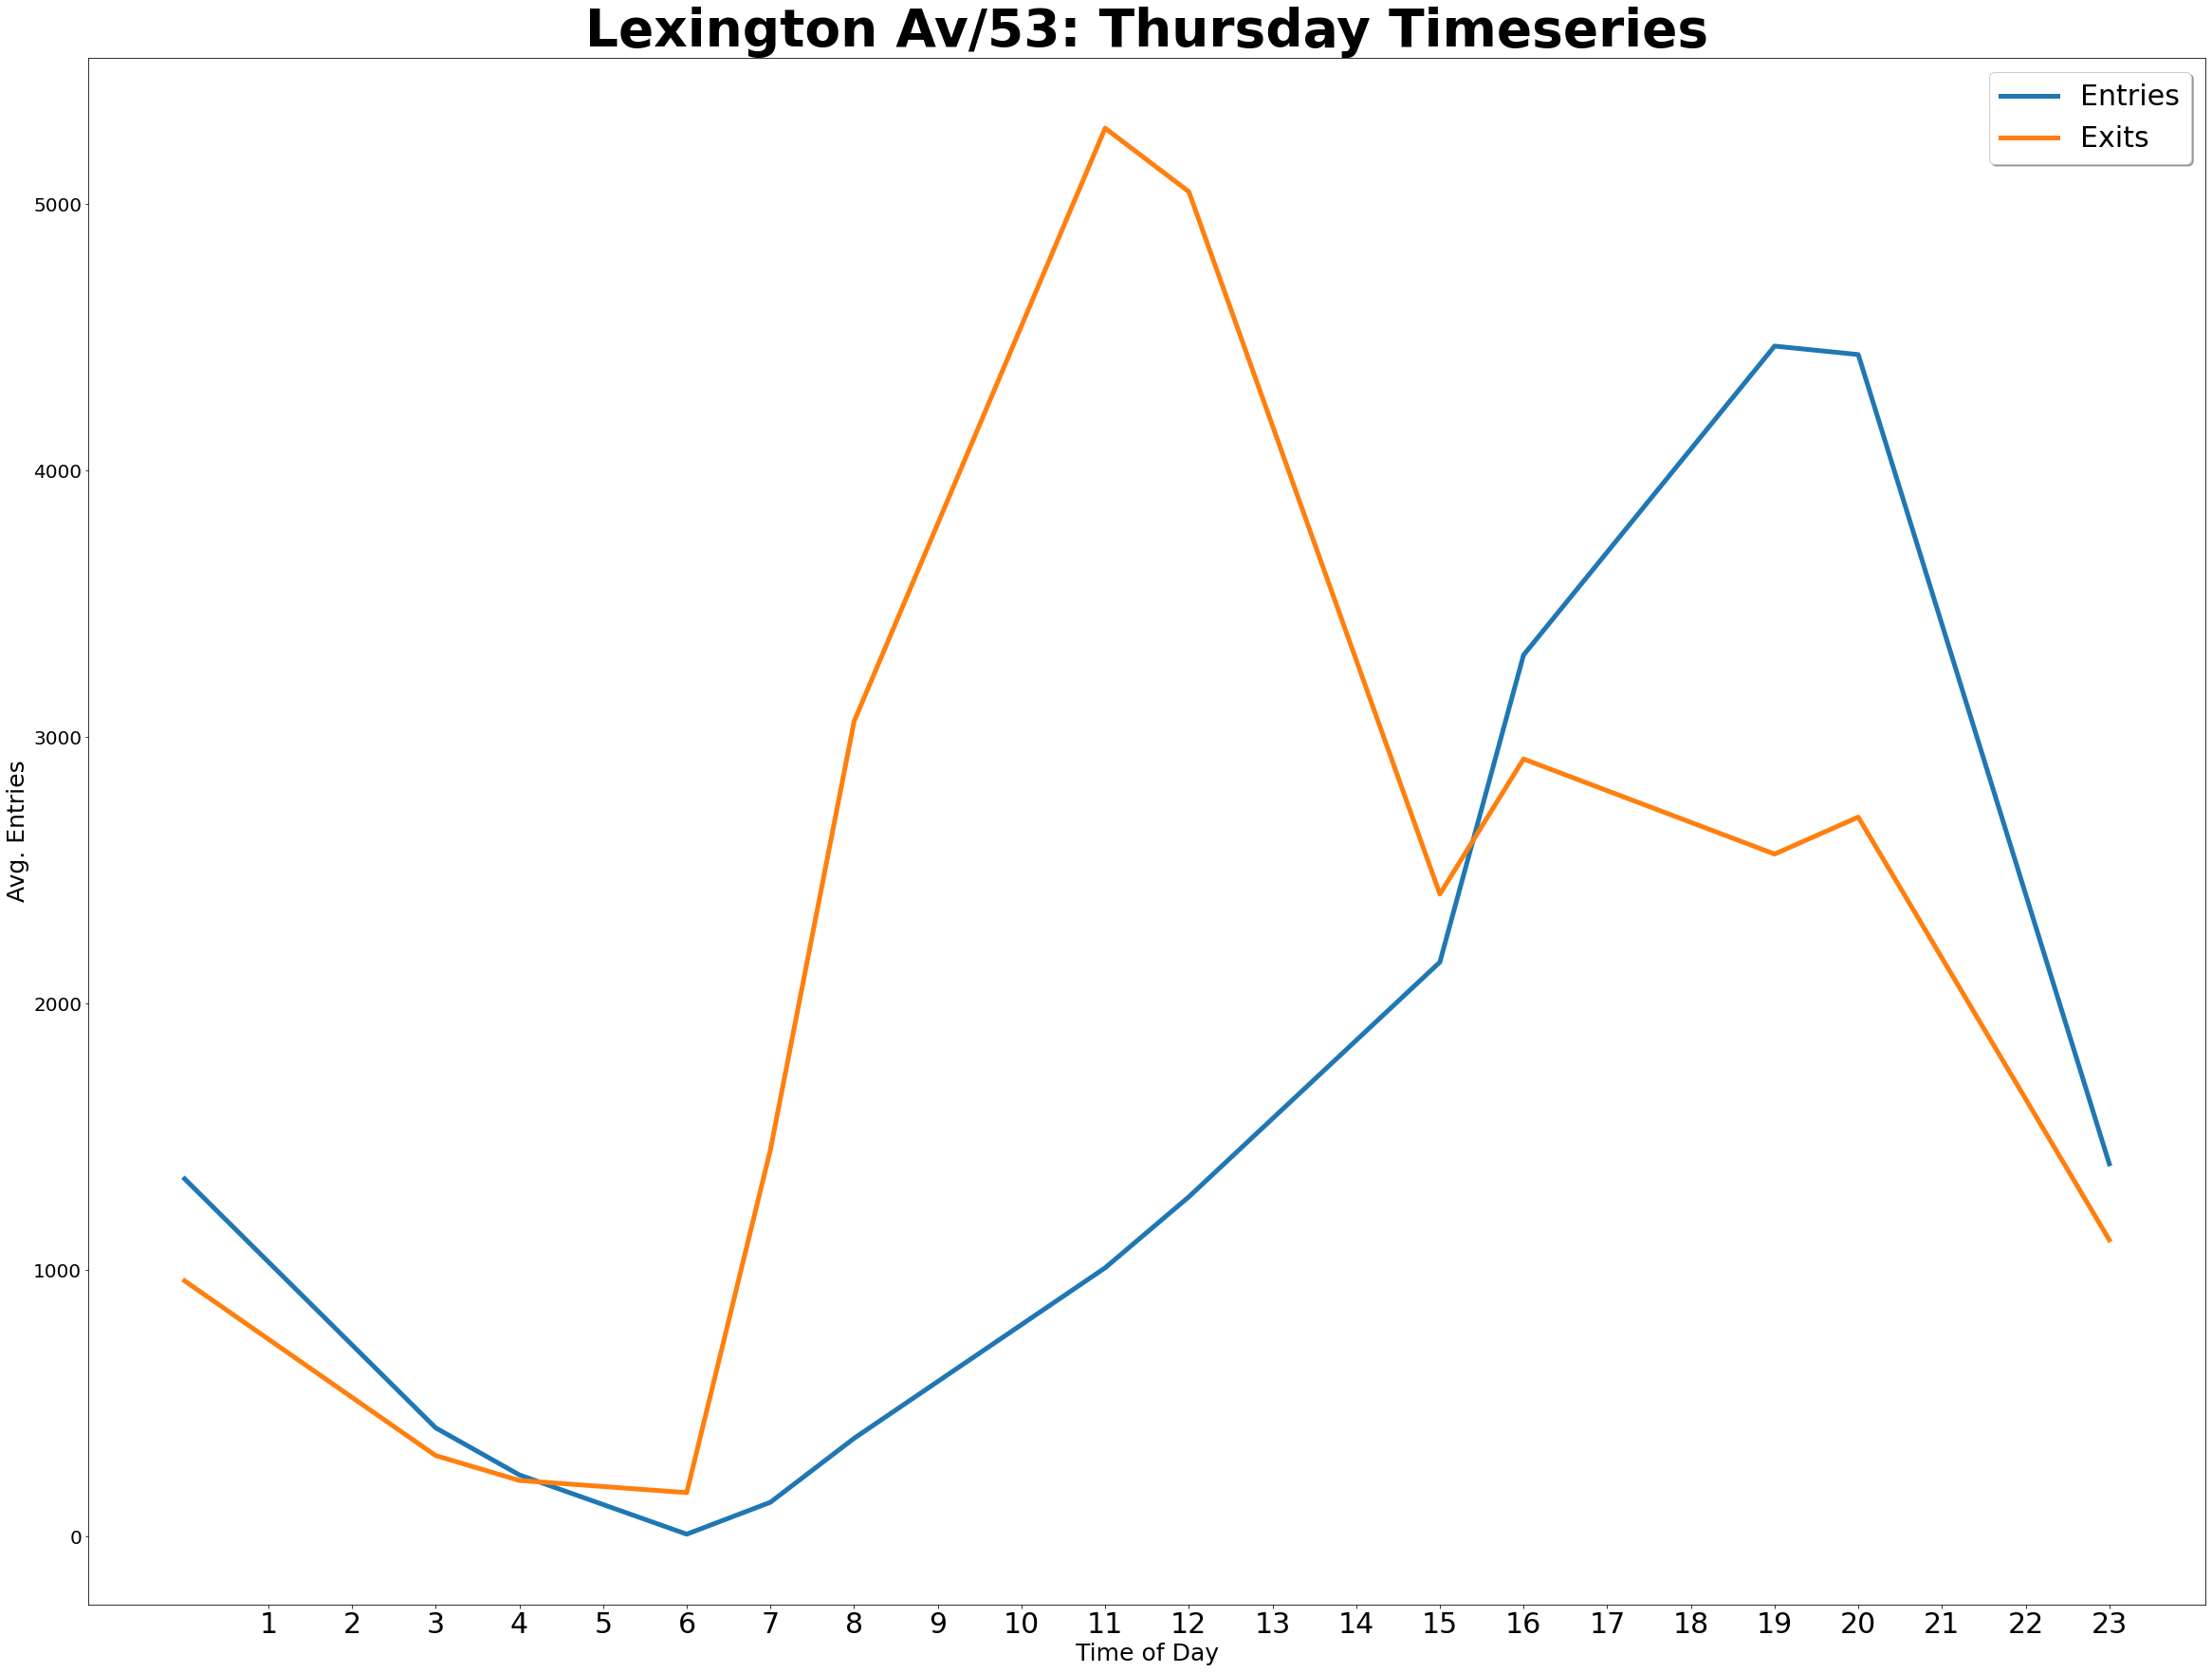

In [62]:
hourly_lx53 = tstiles_lx53.groupby(["day_week","hour"], as_index=False)[['delta_exits', 'delta_entries']].mean()
lx53_thurs=hourly_lx53[hourly_lx53.day_week==4].groupby("hour")[["delta_entries", "delta_exits"]].mean()
plt.figure(figsize=[40,30]) 


plt.plot(lx53_thurs, linewidth= 5, linestyle = '-')

plt.xlabel('Time of Day', fontsize = 25);
plt.ylabel('Avg. Entries', fontsize = 25)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22 ,23], fontsize = 30)
plt.yticks(fontsize = 20)
plt.title('Lexington Av/53: Thursday Timeseries', fontsize = 55, weight = 'bold')
plt.legend(["Entries", "Exits"], shadow=True, loc= 0, fontsize = 30)
plt.savefig("Figures/lexington_53_thurs.png")

## 5 Av

In [63]:
tstiles_5av = tstiles_day[tstiles_day.station == "5 AVE"].copy()
tstiles_5av.sort_values(["delta_entries", "delta_exits"], 
                           ascending = [False, False]).head(45)

tstiles_5av['delta_exits'] = tstiles_5av['delta_exits'].apply(
    lambda x: -50 if x > 10000 else x).astype(int)
tstiles_5av['delta_entries'] = tstiles_5av['delta_entries'].apply(
    lambda x: -50 if x > 10000 else x).astype(int)

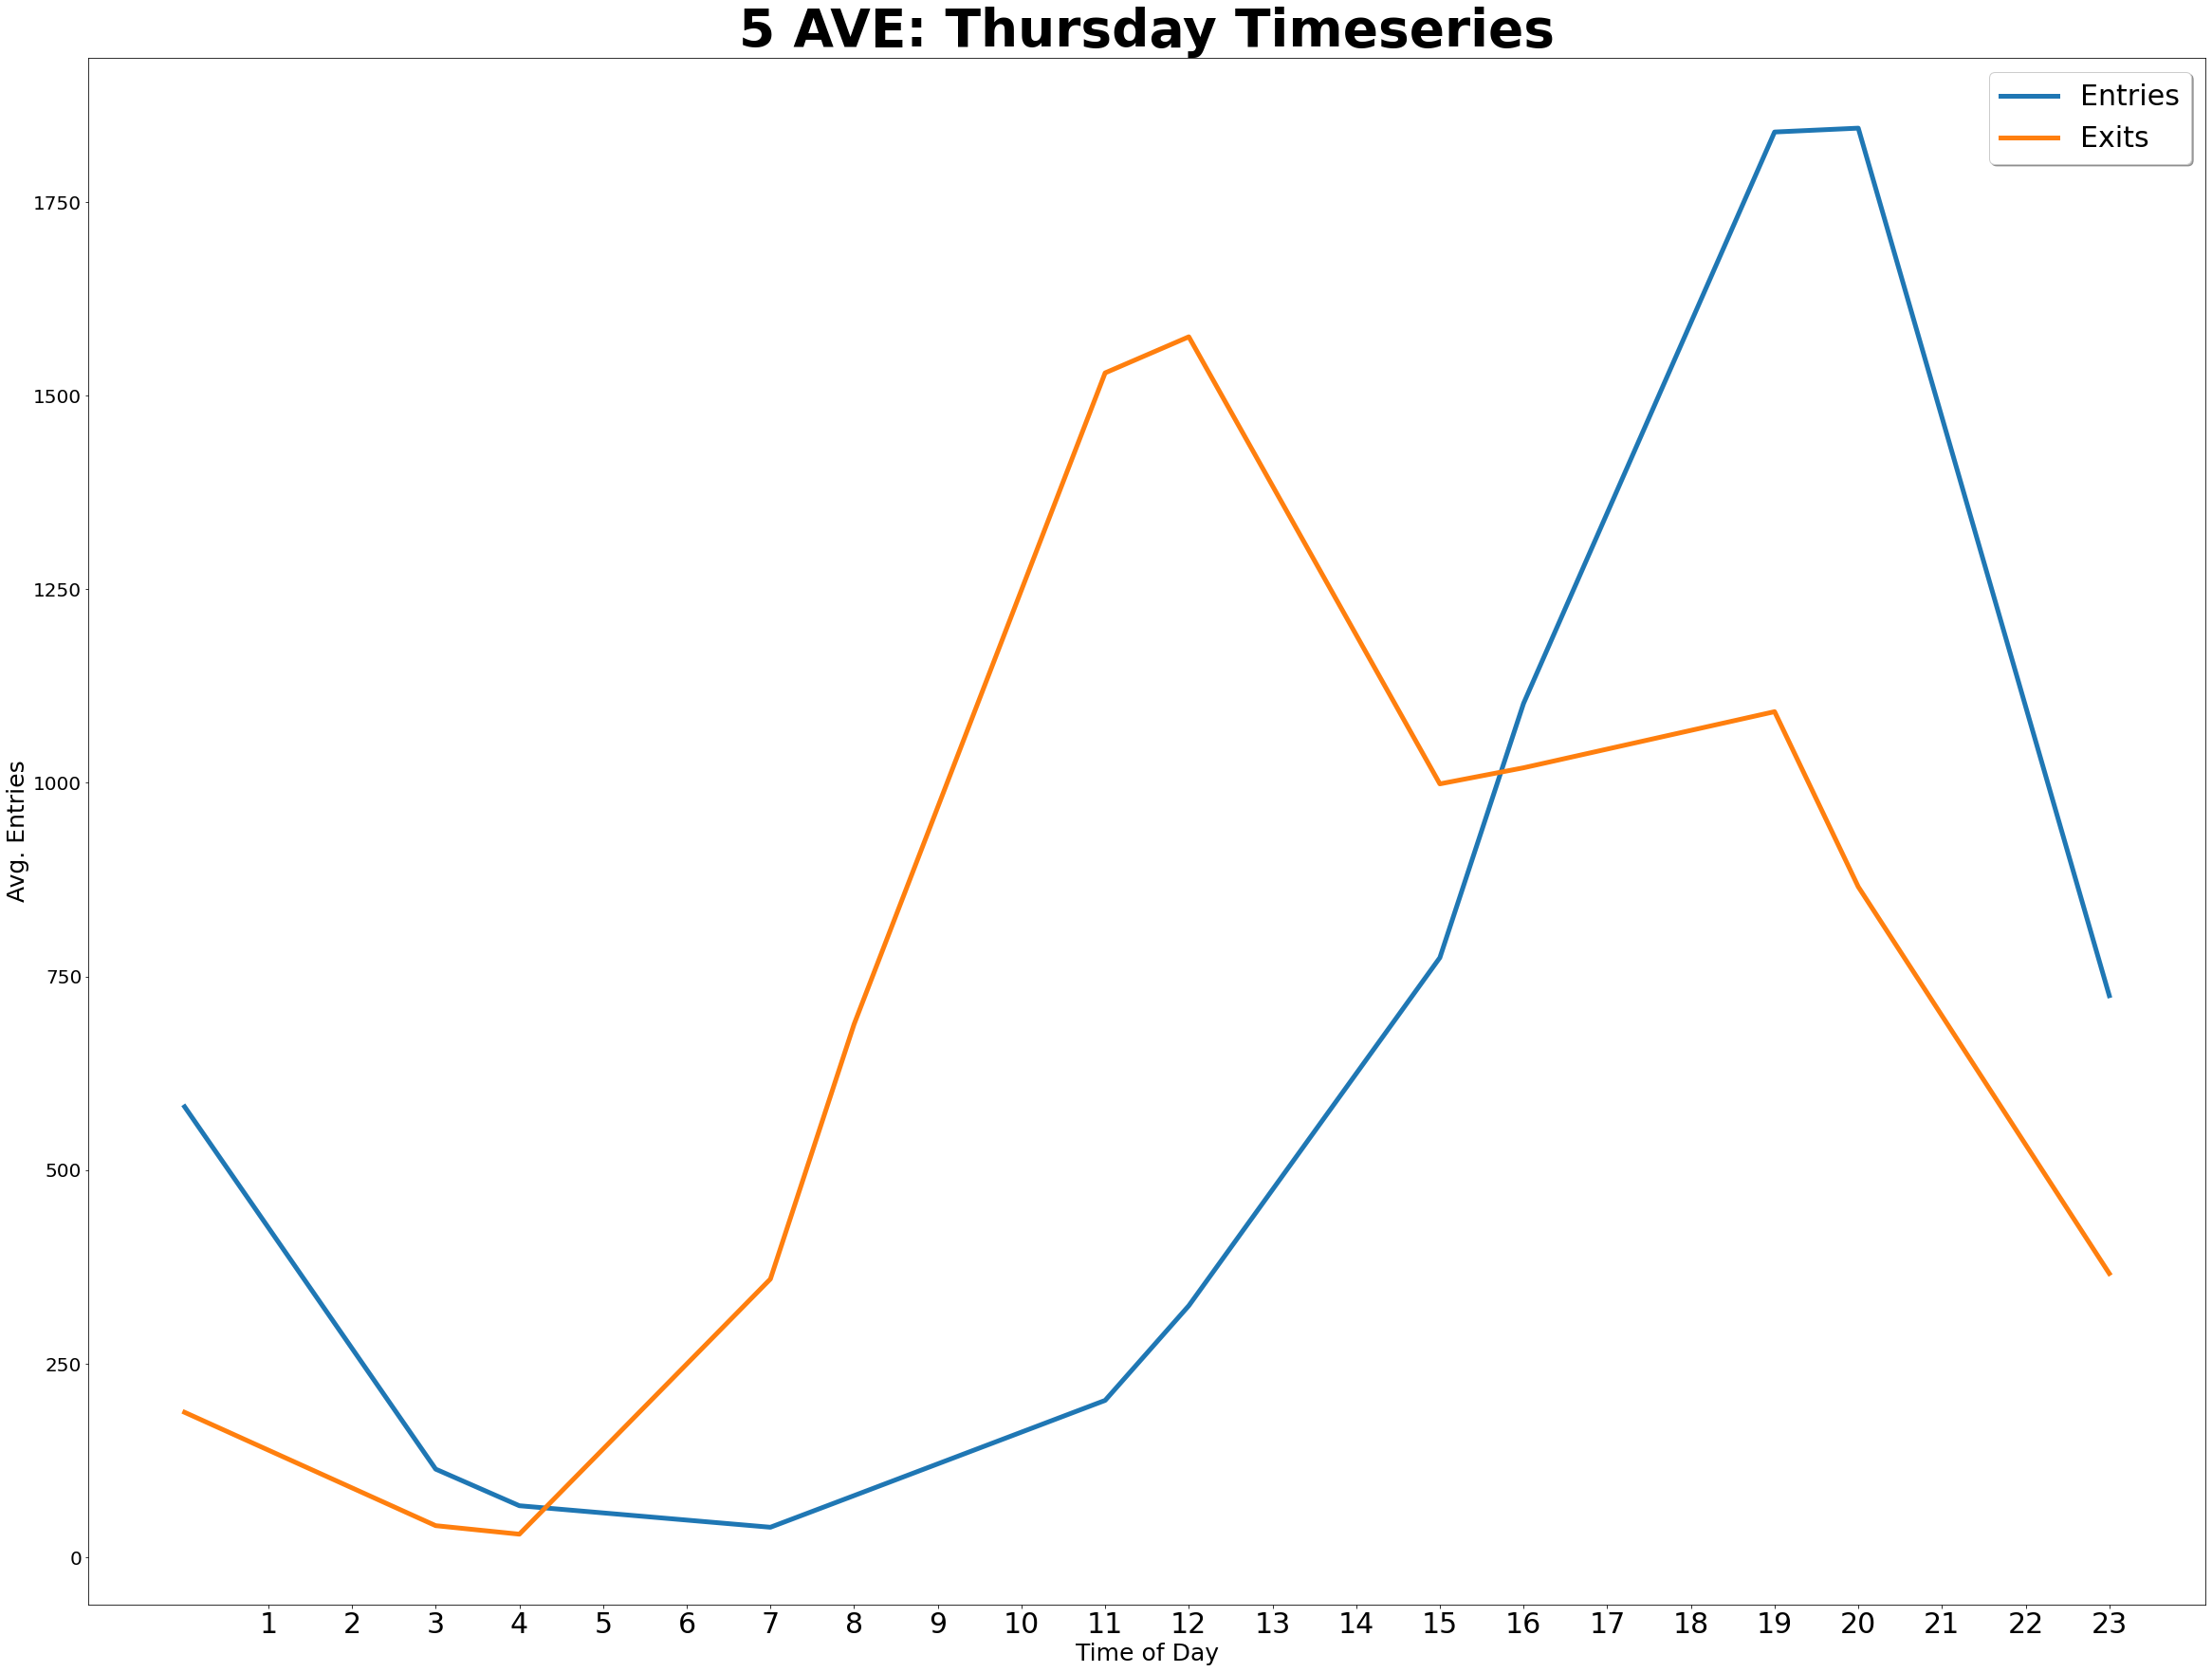

In [64]:
hourly_5av = tstiles_5av.groupby(["day_week","hour"], as_index=False)[['delta_exits', 'delta_entries']].mean()
av5_thurs=hourly_5av[hourly_5av.day_week==4].groupby("hour")[["delta_entries", "delta_exits"]].mean()
plt.figure(figsize=[40,30]) 


plt.plot(av5_thurs, linewidth= 5, linestyle = '-')

plt.xlabel('Time of Day', fontsize = 25);
plt.ylabel('Avg. Entries', fontsize = 25)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22 ,23], fontsize = 30)
plt.yticks(fontsize = 20)
plt.title('5 AVE: Thursday Timeseries', fontsize = 55, weight = 'bold')
plt.legend(["Entries", "Exits"], shadow=True, loc= 0, fontsize = 30)
plt.savefig("Figures/5av_thurs.png")

## Greenpoint Av

In [65]:
tstiles_green = tstiles_day[tstiles_day.station == "GREENPOINT AV"].copy()
tstiles_green.sort_values(["delta_entries", "delta_exits"], 
                           ascending = [False, False]).head(45)

tstiles_green['delta_exits'] = tstiles_green['delta_exits'].apply(
    lambda x: -50 if x > 10000 else x).astype(int)
tstiles_green['delta_entries'] = tstiles_green['delta_entries'].apply(
    lambda x: -50 if x > 10000 else x).astype(int)

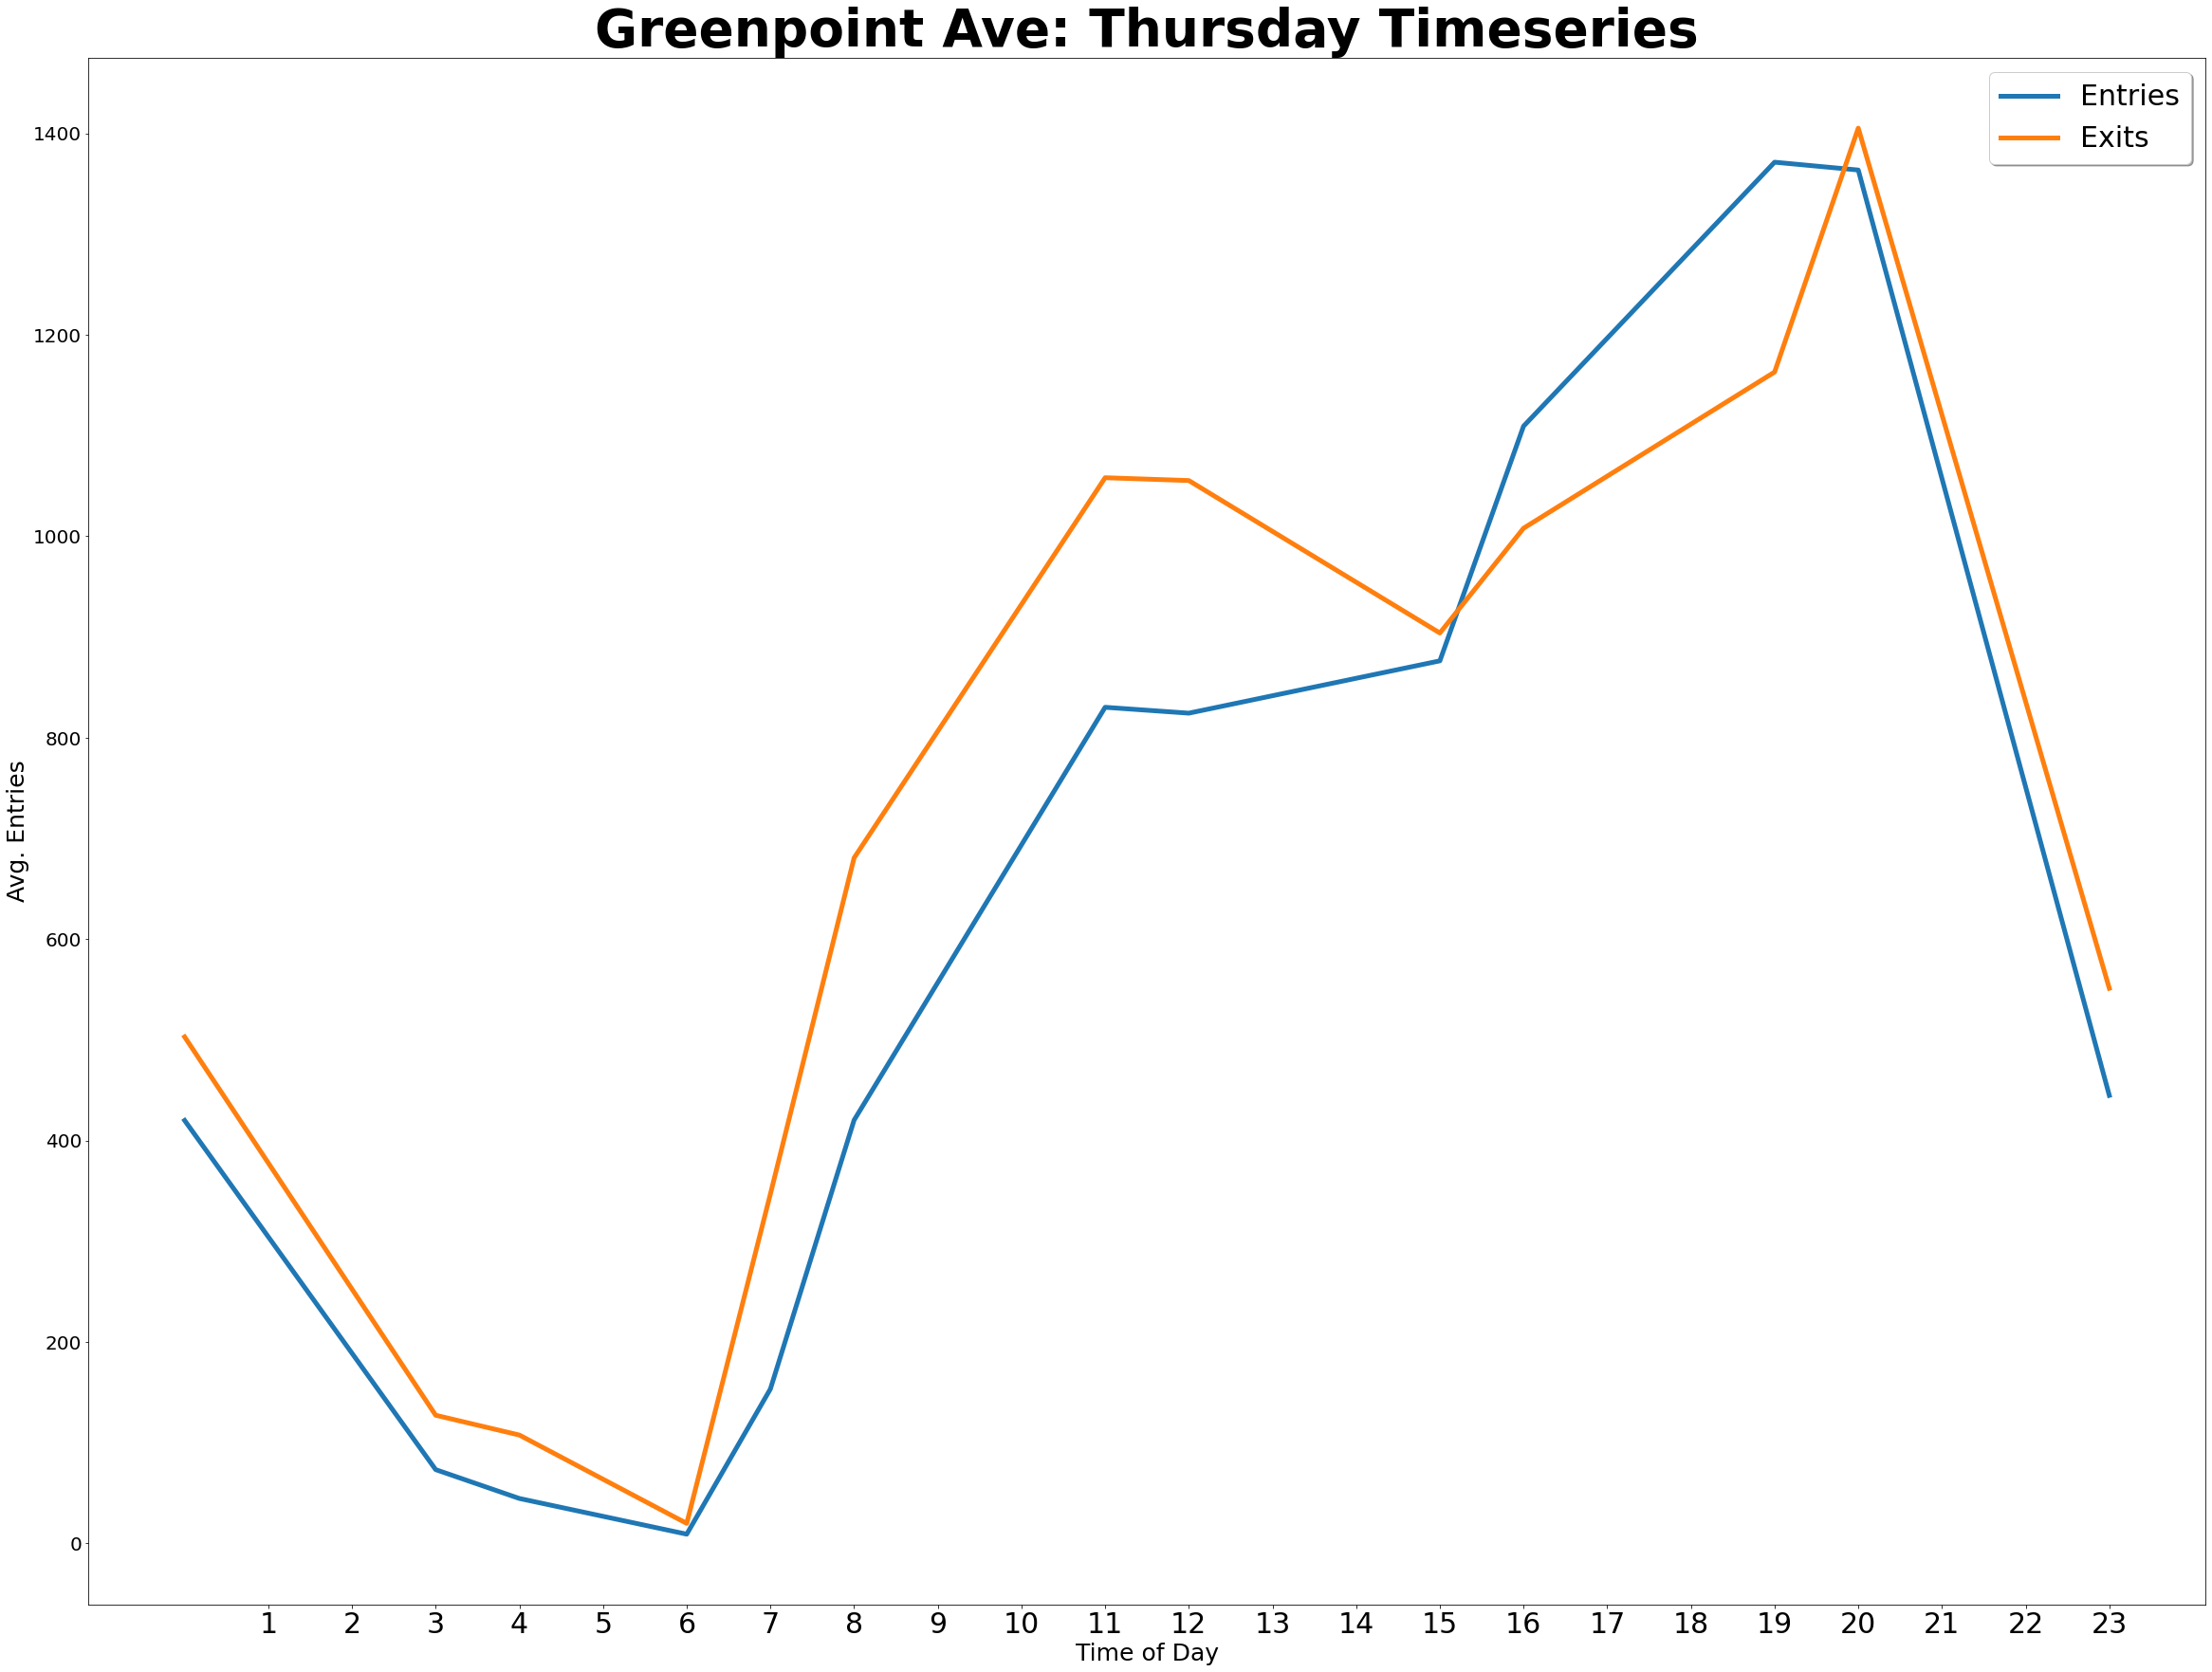

In [66]:
hourly_green = tstiles_green.groupby(["day_week","hour"], as_index=False)[['delta_exits', 'delta_entries']].mean()
green_thurs=hourly_green[hourly_green.day_week==4].groupby("hour")[["delta_entries", "delta_exits"]].mean()
plt.figure(figsize=[40,30]) 


plt.plot(green_thurs, linewidth= 5, linestyle = '-')

plt.xlabel('Time of Day', fontsize = 25);
plt.ylabel('Avg. Entries', fontsize = 25)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22 ,23], fontsize = 30)
plt.yticks(fontsize = 20)
plt.title('Greenpoint Ave: Thursday Timeseries', fontsize = 55, weight = 'bold')
plt.legend(["Entries", "Exits"], shadow=True, loc= 0, fontsize = 30)
plt.savefig("Figures/greenpoint_av_thurs.png")

# 40 St- Lowery St

In [67]:
tstiles_low40 = tstiles_day[tstiles_day.station == "40 ST LOWERY ST"].copy()
tstiles_low40.sort_values(["delta_entries", "delta_exits"], 
                           ascending = [False, False]).head(45)

tstiles_low40['delta_exits'] = tstiles_low40['delta_exits'].apply(
    lambda x: -50 if x > 10000 else x).astype(int)
tstiles_low40['delta_entries'] = tstiles_low40['delta_entries'].apply(
    lambda x: -50 if x > 10000 else x).astype(int)

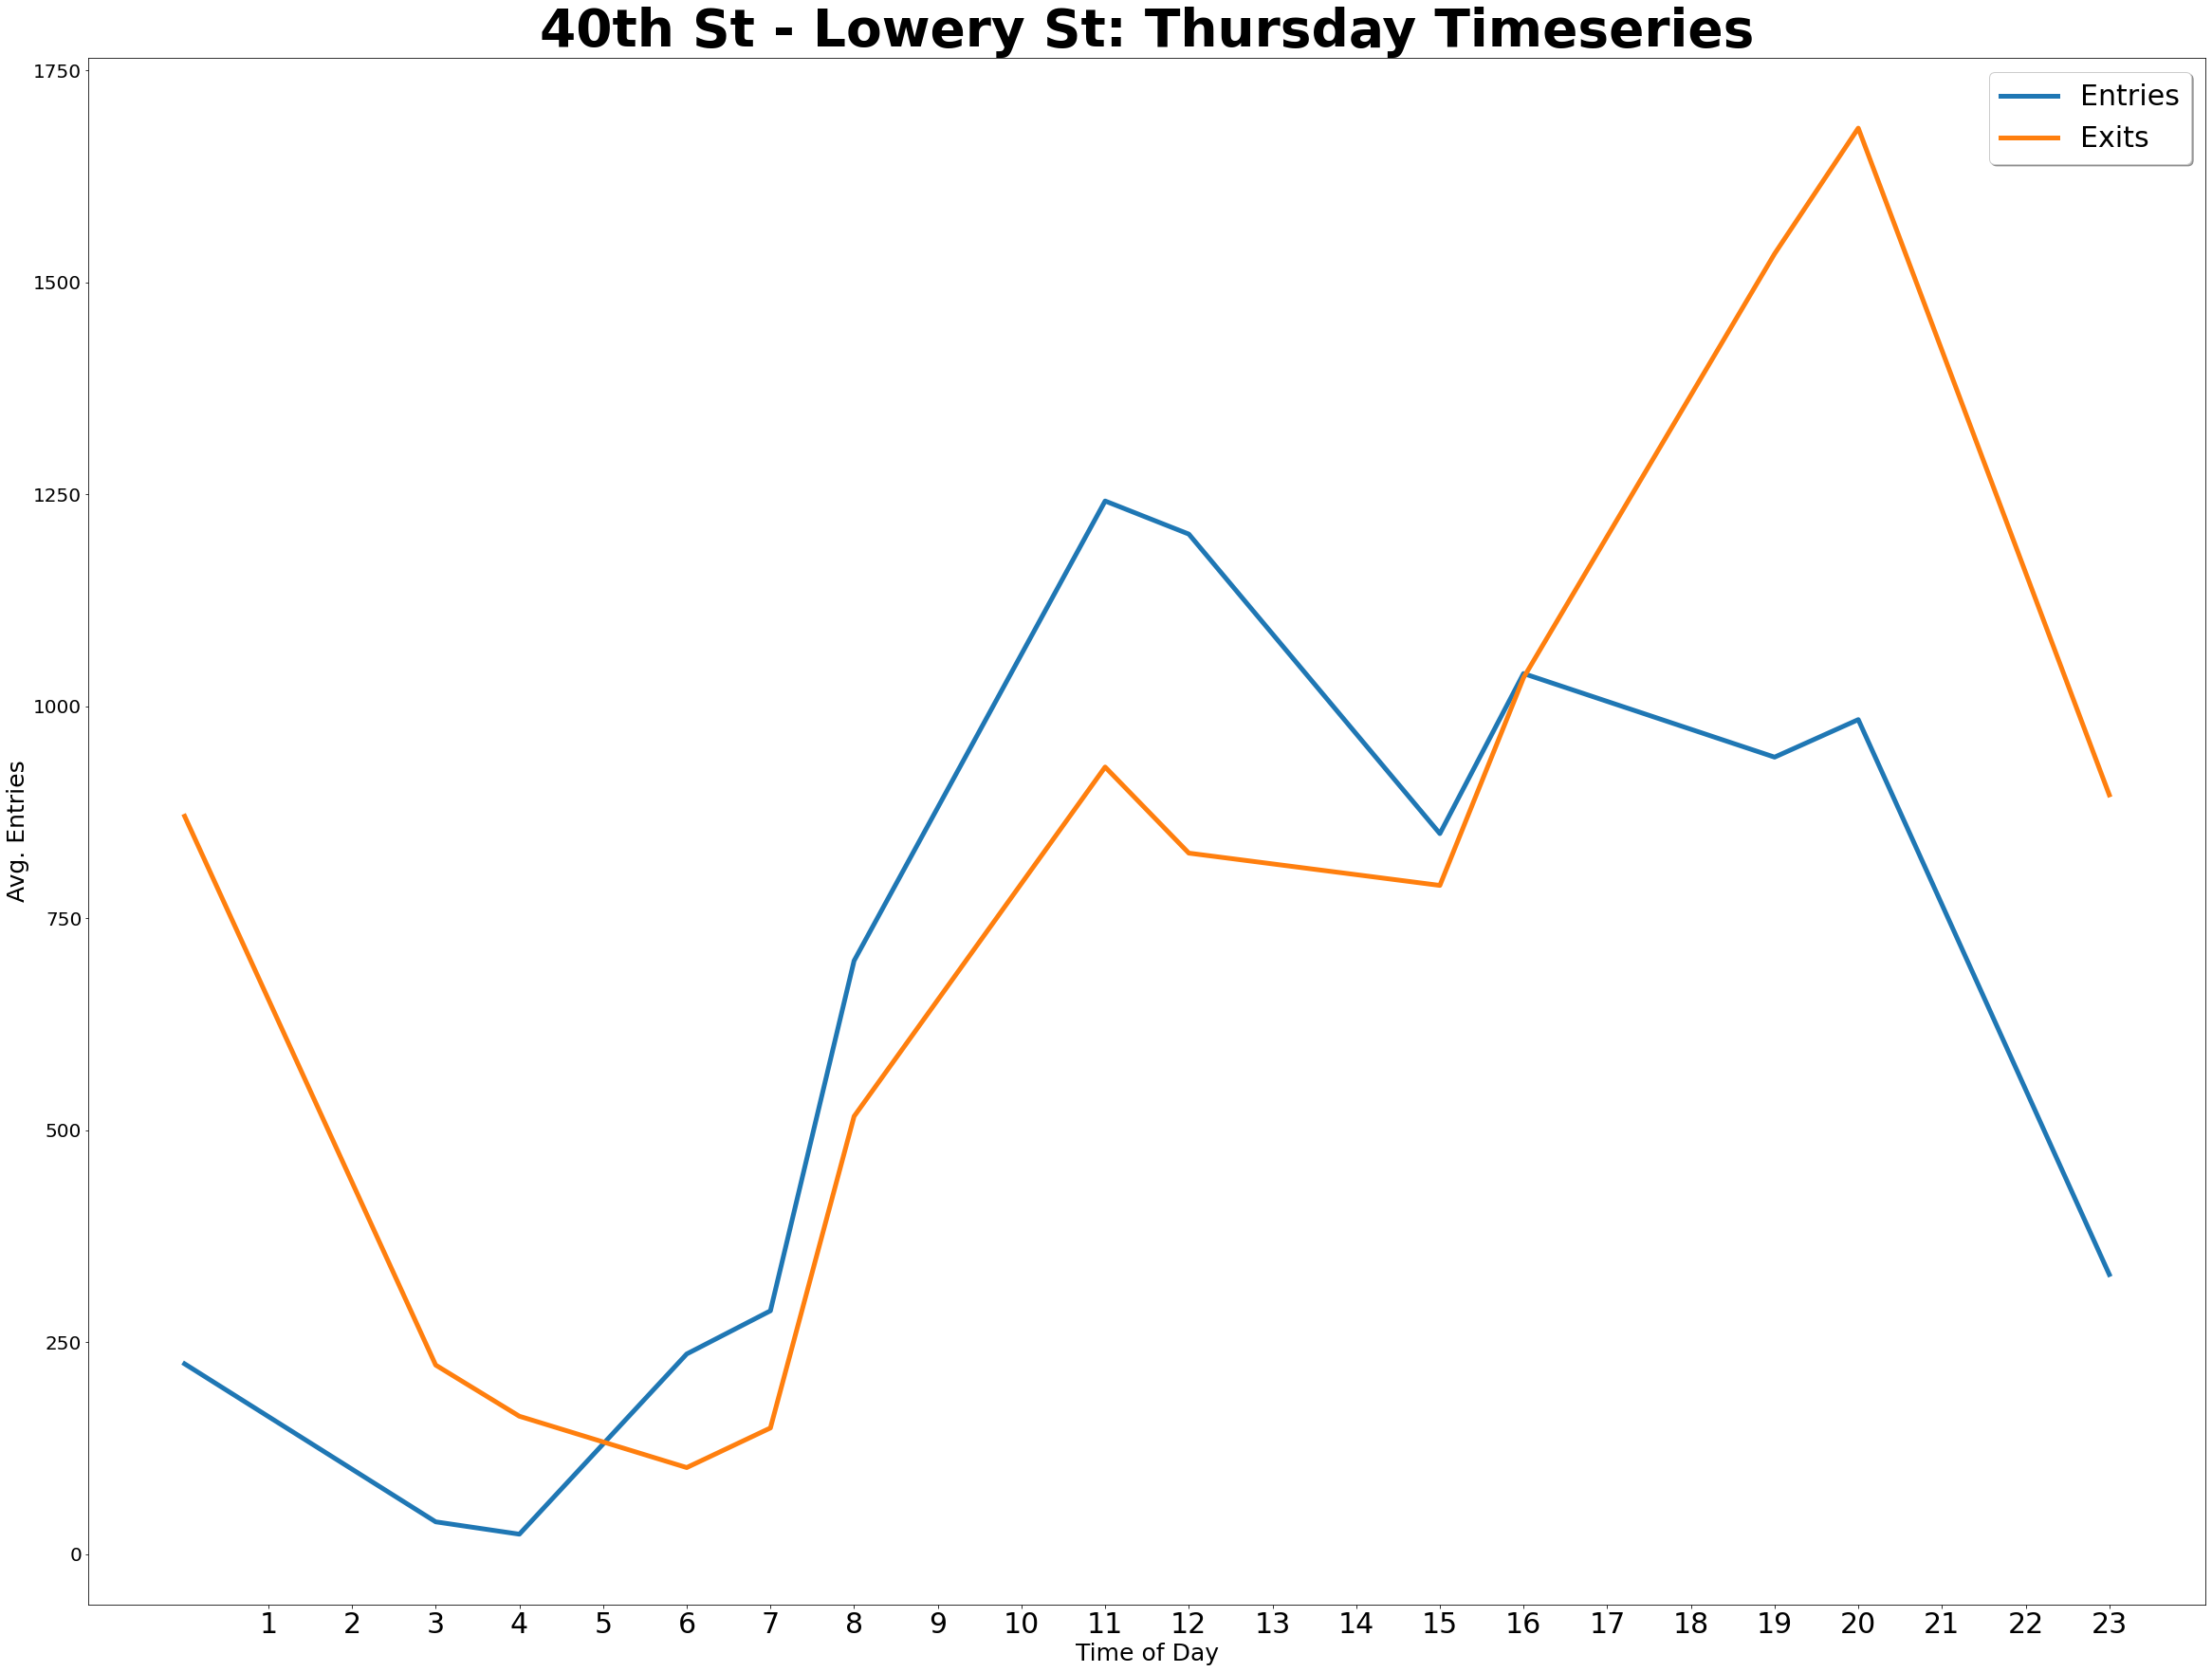

In [68]:
hourly_low40 = tstiles_low40.groupby(["day_week","hour"], as_index=False)[['delta_exits', 'delta_entries']].mean()
low40_thurs=hourly_low40[hourly_low40.day_week==4].groupby("hour")[["delta_entries", "delta_exits"]].mean()
plt.figure(figsize=[40,30]) 


plt.plot(low40_thurs, linewidth= 5, linestyle = '-')

plt.xlabel('Time of Day', fontsize = 25);
plt.ylabel('Avg. Entries', fontsize = 25)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22 ,23], fontsize = 30)
plt.yticks(fontsize = 20)
plt.title('40th St - Lowery St: Thursday Timeseries', fontsize = 55, weight = 'bold')
plt.legend(["Entries", "Exits"], shadow=True, loc= 0, fontsize = 30)
plt.savefig("Figures/40st_loweryst_thurs.png")

# 36 ST

In [69]:
tstiles_36st = tstiles_day[tstiles_day.station == "36 ST"].copy()
tstiles_36st.sort_values(["delta_entries", "delta_exits"], 
                           ascending = [False, False]).head(45)

tstiles_36st['delta_exits'] = tstiles_36st['delta_exits'].apply(
    lambda x: -50 if x > 10000 else x).astype(int)
tstiles_36st['delta_entries'] = tstiles_36st['delta_entries'].apply(
    lambda x: -50 if x > 10000 else x).astype(int)

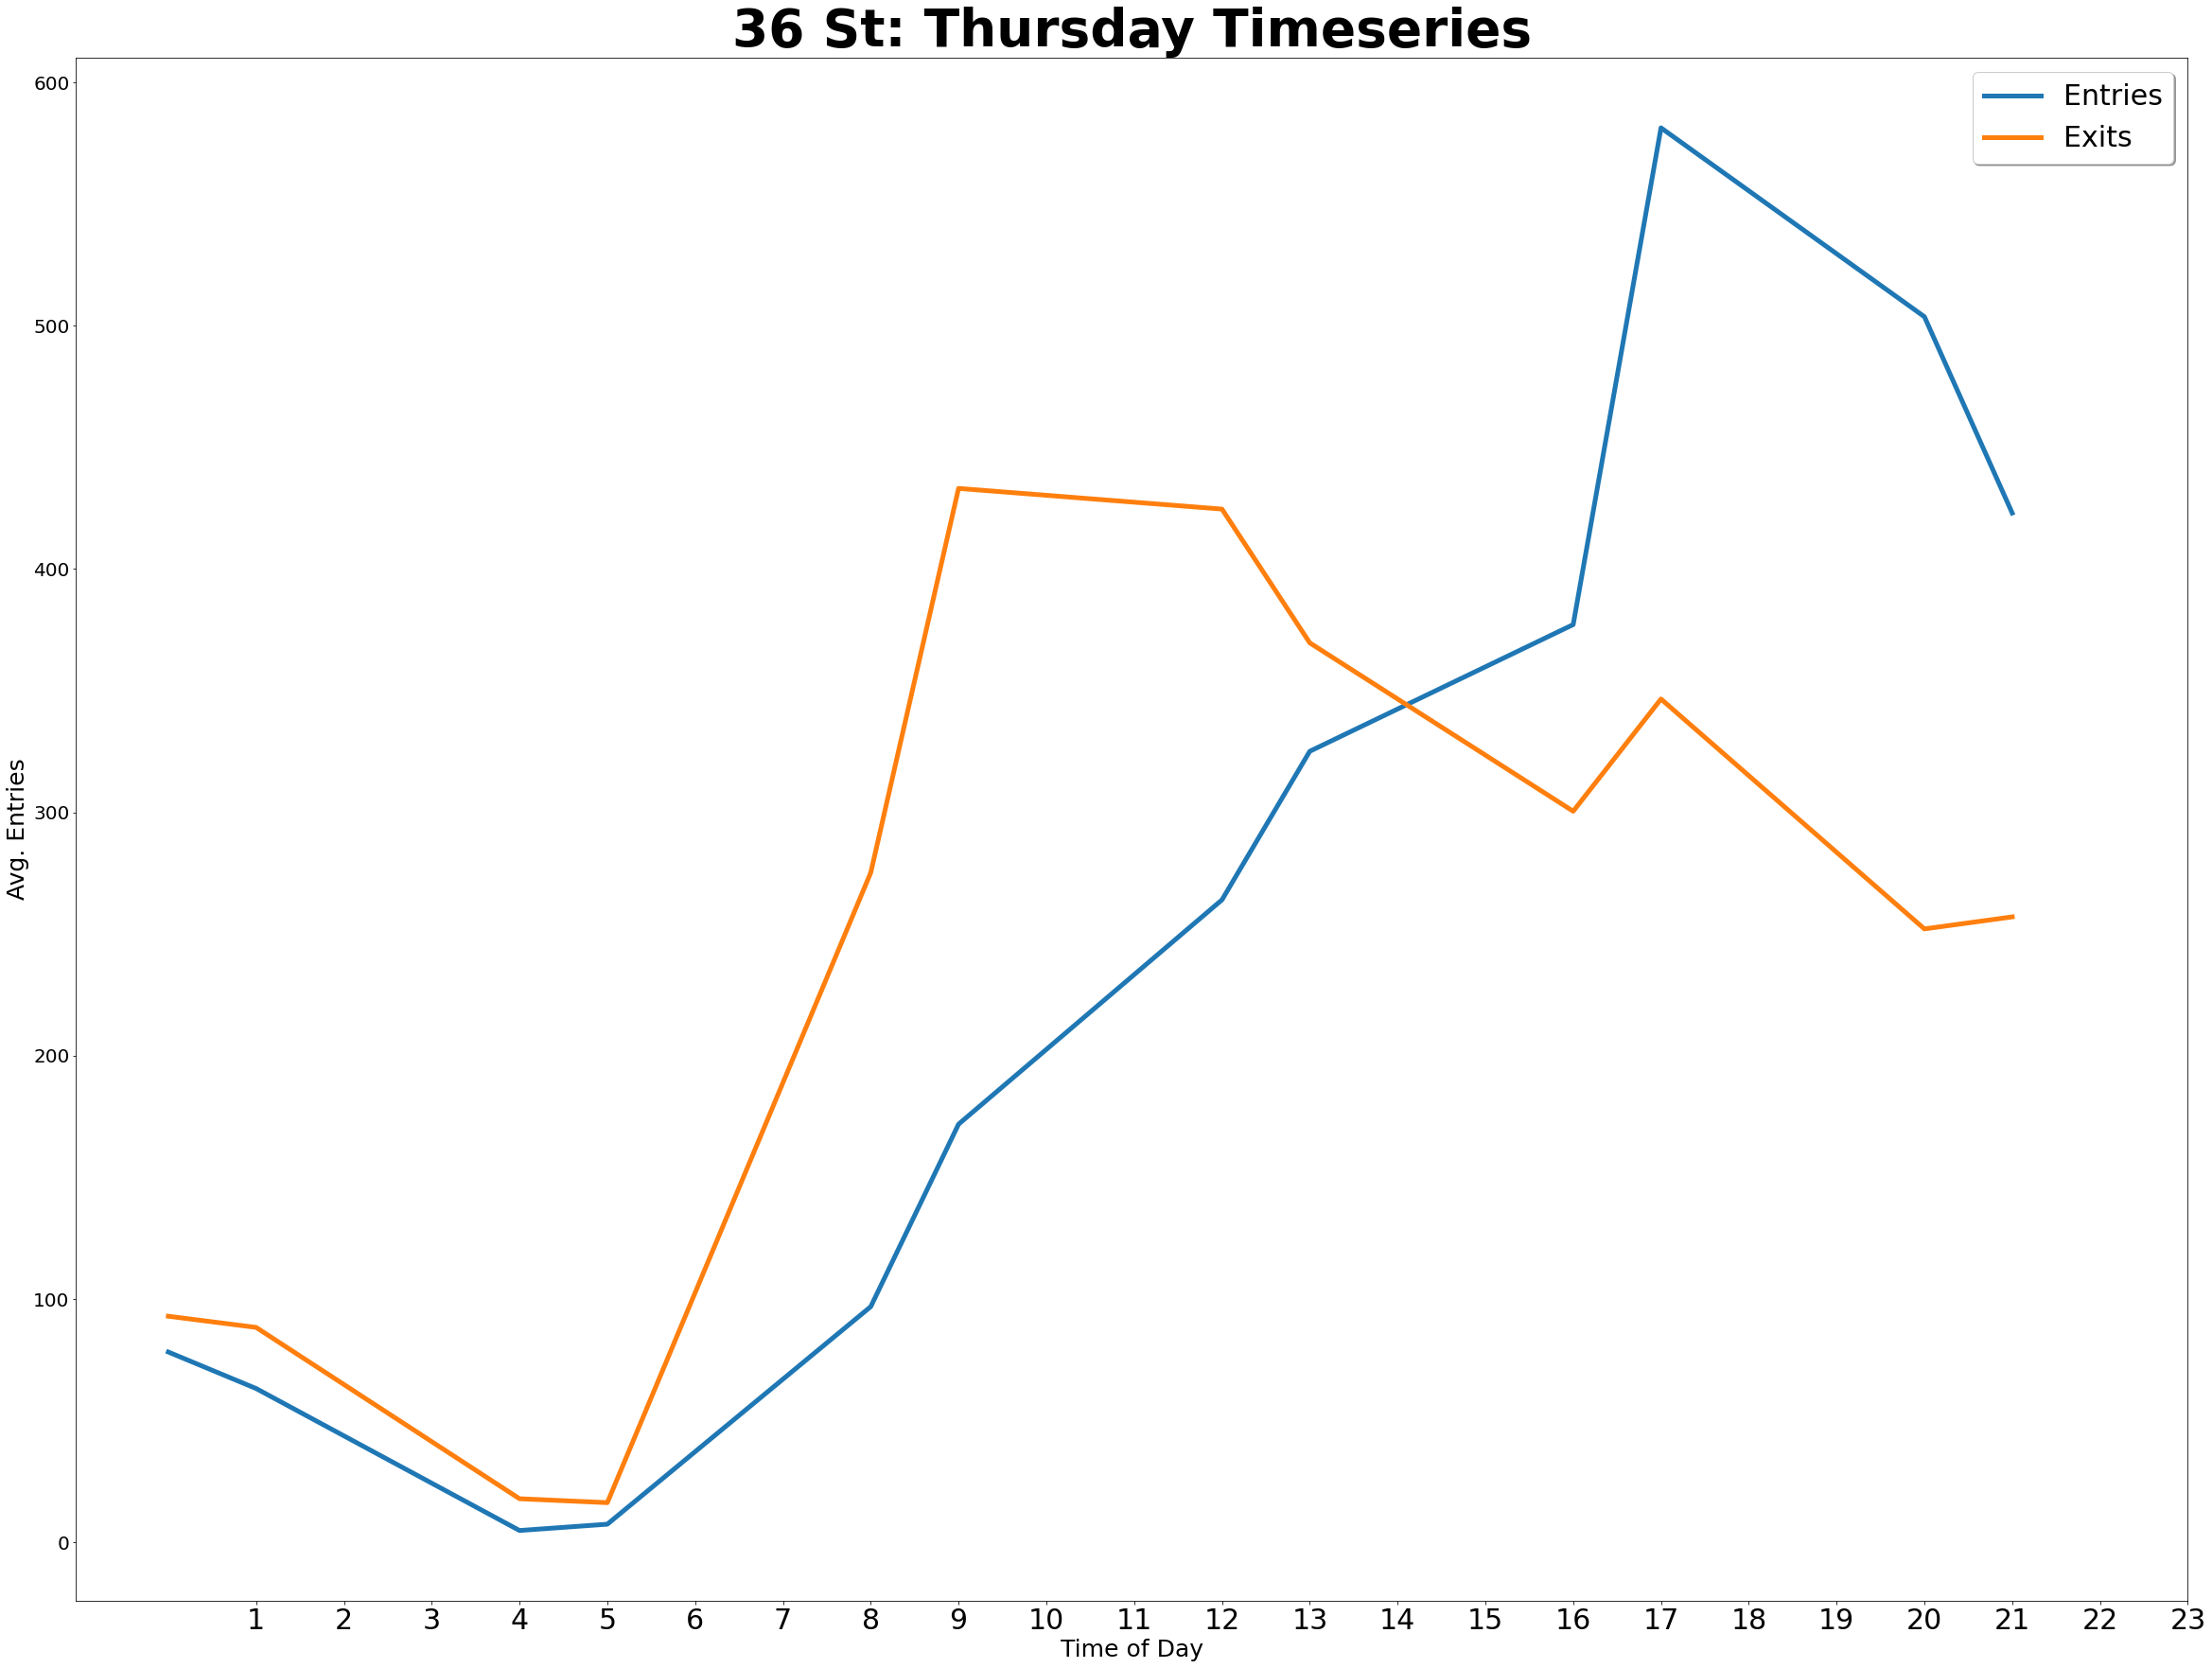

In [70]:
hourly_36st = tstiles_36st.groupby(["day_week","hour"], as_index=False)[['delta_exits', 'delta_entries']].mean()
thurs_36st=hourly_36st[hourly_36st.day_week==4].groupby("hour")[["delta_entries", "delta_exits"]].mean()
plt.figure(figsize=[40,30]) 


plt.plot(thurs_36st, linewidth= 5, linestyle = '-')

plt.xlabel('Time of Day', fontsize = 25);
plt.ylabel('Avg. Entries', fontsize = 25)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22 ,23], fontsize = 30)
plt.yticks(fontsize = 20)
plt.title('36 St: Thursday Timeseries', fontsize = 55, weight = 'bold')
plt.legend(["Entries", "Exits"], shadow=True, loc= 0, fontsize = 30)
plt.savefig("Figures/36st_thurs.png")


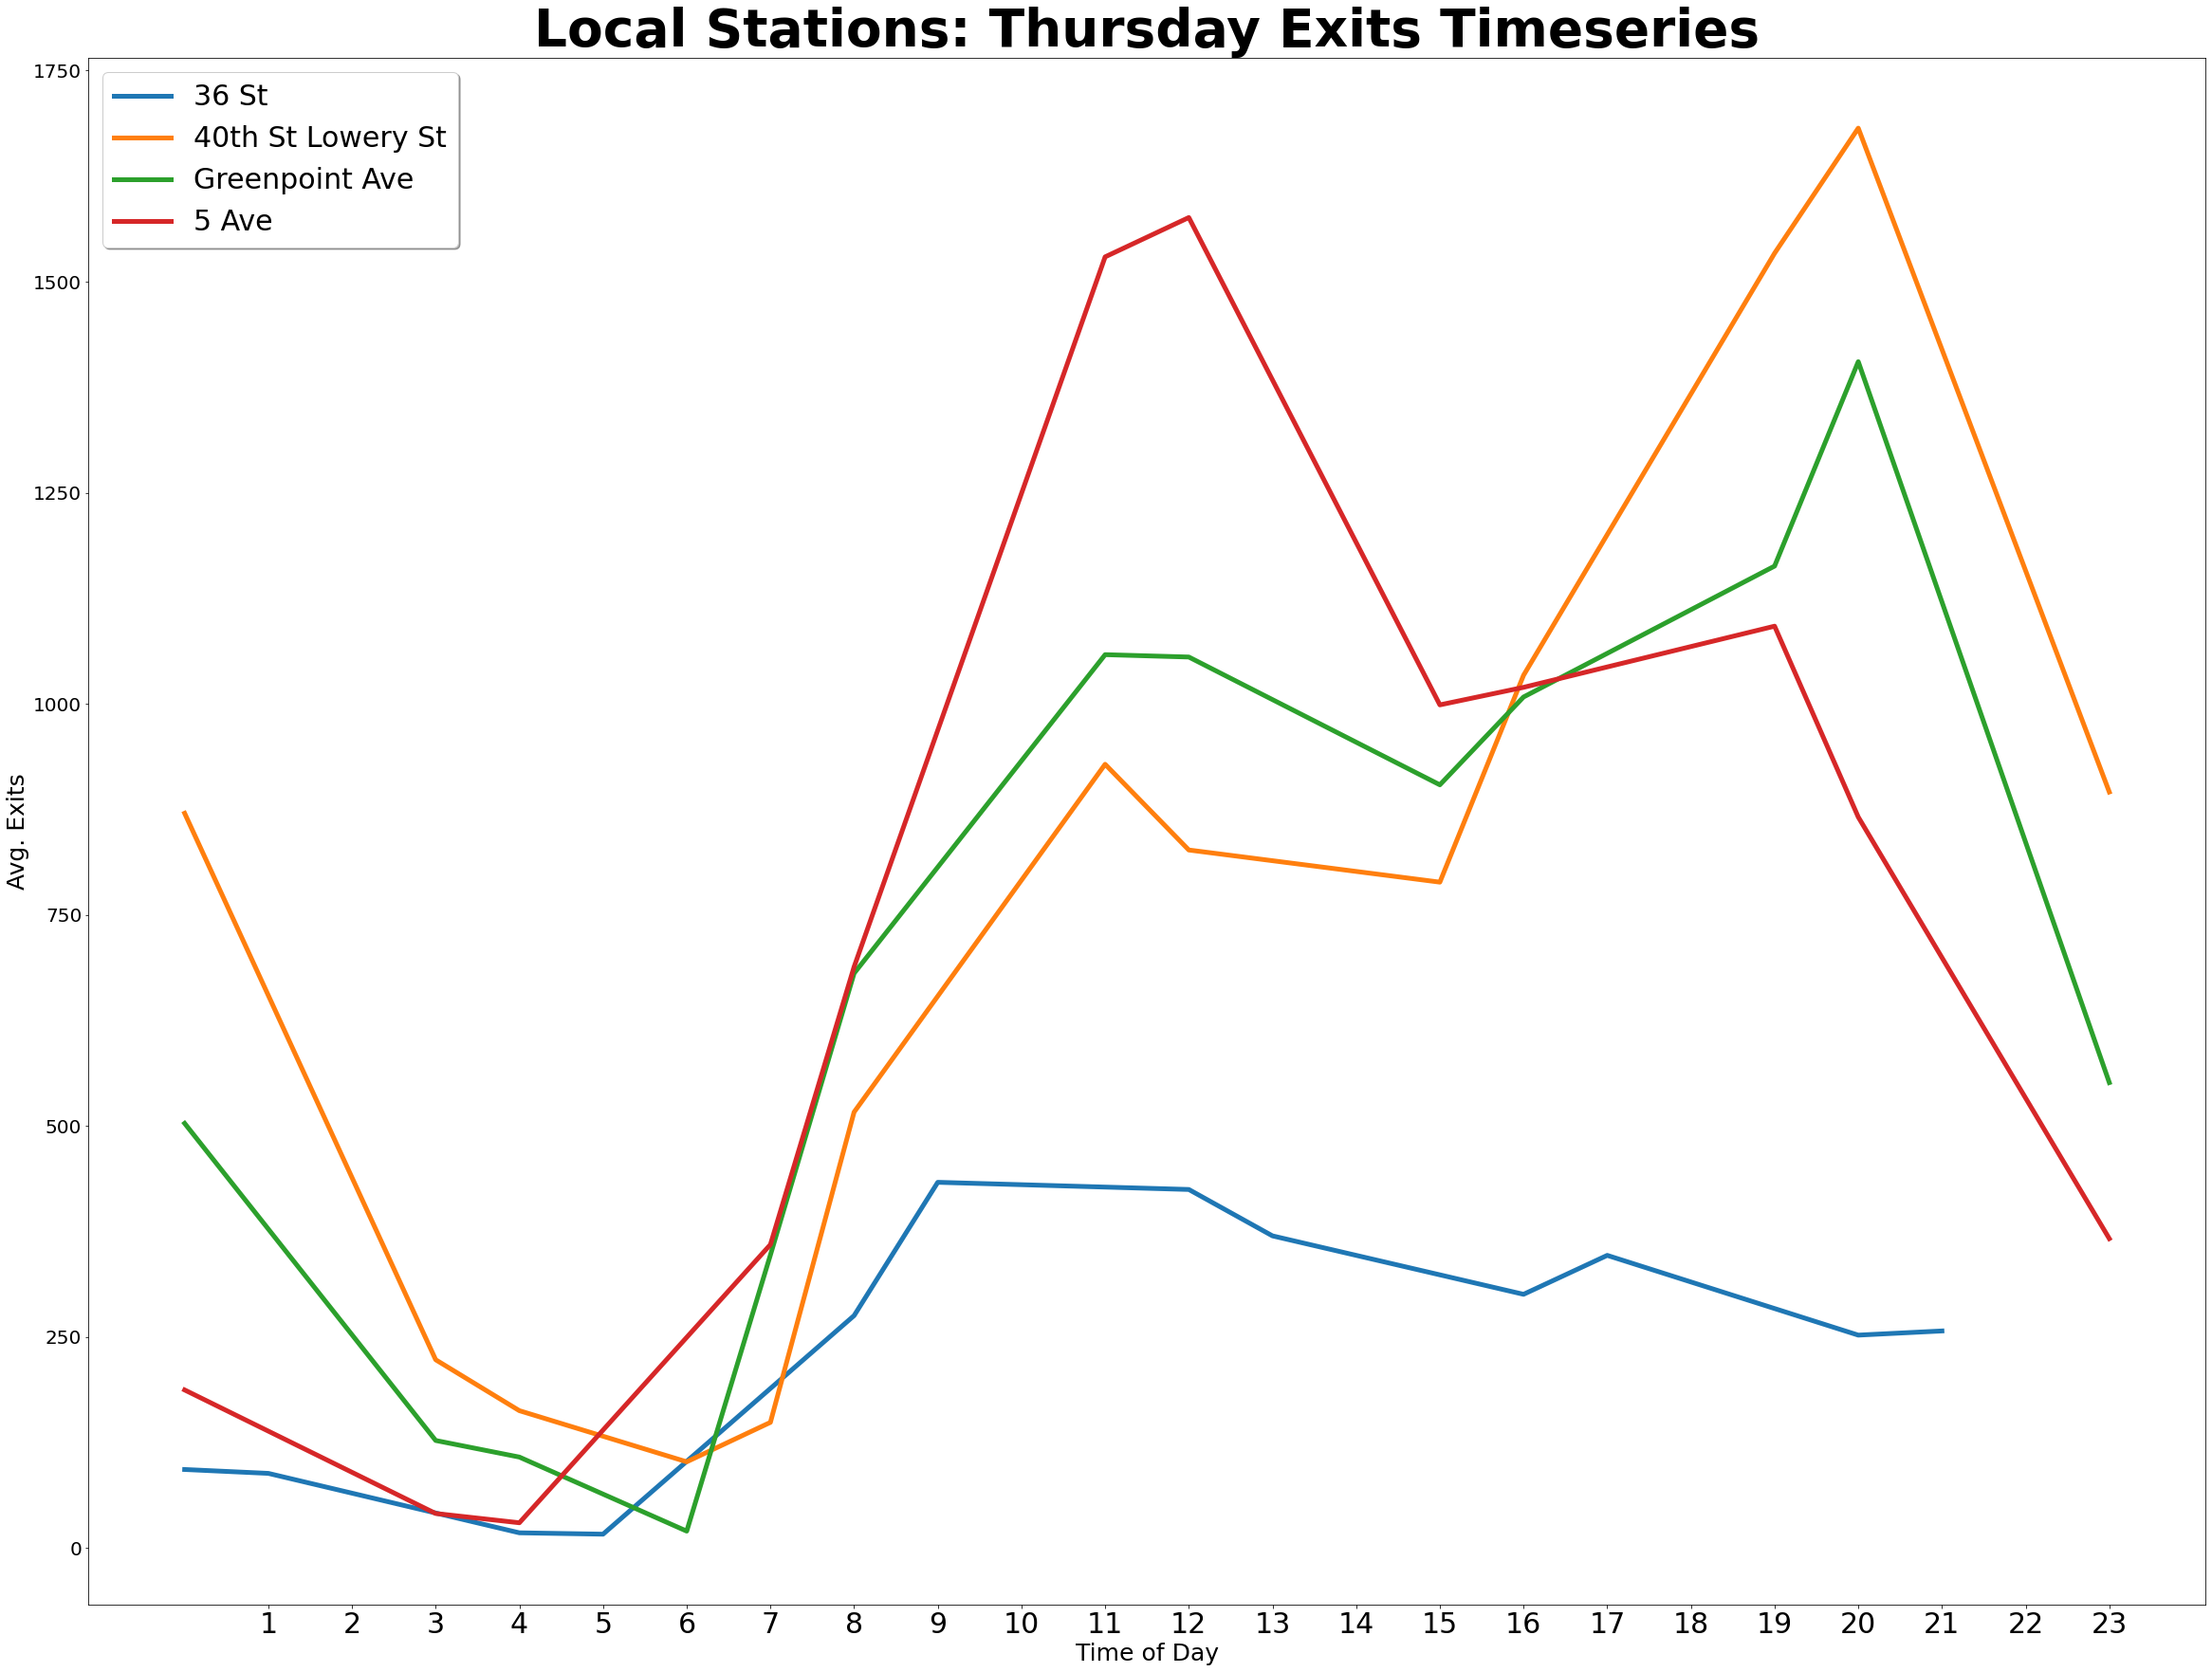

In [71]:
plt.figure(figsize=[40,30]) 


plt.plot(thurs_36st.delta_exits, linewidth= 5, linestyle = '-')
plt.plot(low40_thurs.delta_exits,  linewidth= 5, linestyle = '-')
plt.plot(green_thurs.delta_exits, linewidth= 5, linestyle = '-')
plt.plot(av5_thurs.delta_exits, linewidth= 5, linestyle = '-')

plt.xlabel('Time of Day', fontsize = 25);
plt.ylabel('Avg. Exits', fontsize = 25)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22 ,23], fontsize = 30)
plt.yticks(fontsize = 20)
plt.title('Local Stations: Thursday Exits Timeseries', fontsize = 55, weight = 'bold')
plt.legend(["36 St", "40th St Lowery St", "Greenpoint Ave", "5 Ave"],
           shadow=True, loc= 0, fontsize = 30)

plt.savefig("Figures/local_stations_thurs.png")

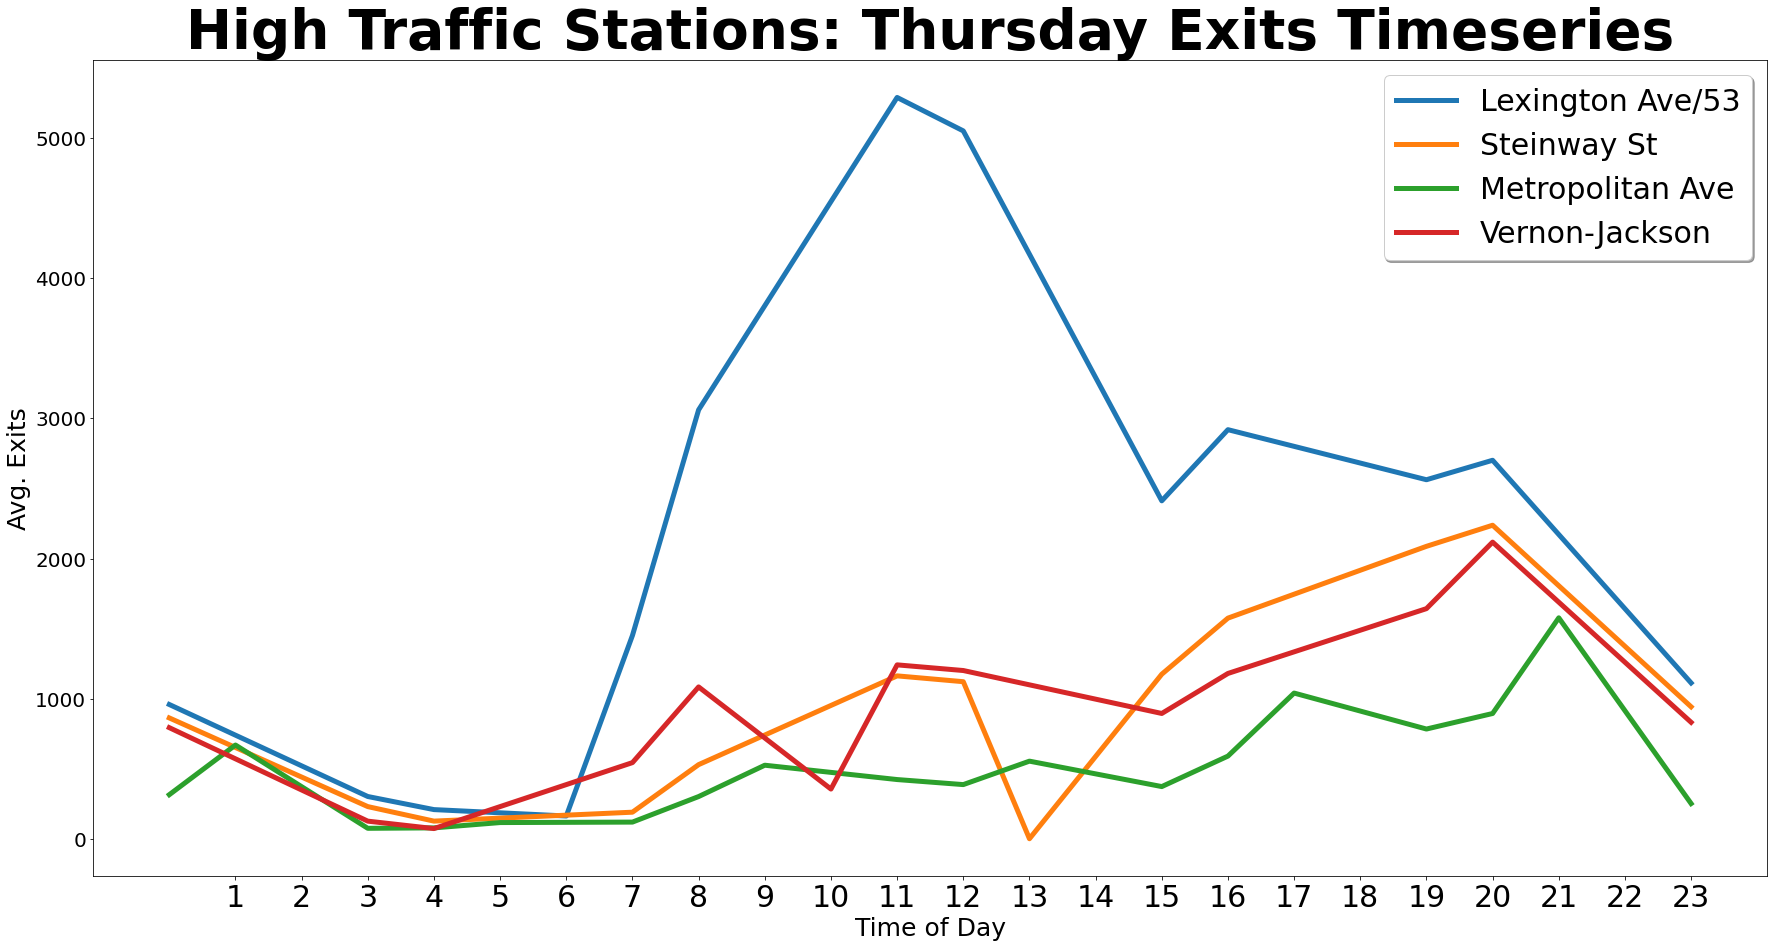

In [76]:
plt.figure(figsize=[30,15]) 


plt.plot(lx53_thurs.delta_exits, linewidth= 5, linestyle = '-')
plt.plot(stnwy_thurs.delta_exits,  linewidth= 5, linestyle = '-')
plt.plot(metrop_thurs.delta_exits, linewidth= 5, linestyle = '-')
plt.plot(vjack_thurs.delta_exits, linewidth= 5, linestyle = '-')

plt.xlabel('Time of Day', fontsize = 25);
plt.ylabel('Avg. Exits', fontsize = 25)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22 ,23], fontsize = 30)
plt.yticks(fontsize = 20)
plt.title('High Traffic Stations: Thursday Exits Timeseries', fontsize = 55, weight = 'bold')
plt.legend(
    ["Lexington Ave/53", "Steinway St",
     "Metropolitan Ave", "Vernon-Jackson"],
    shadow=True, loc= 0, fontsize = 30)
plt.savefig("Figures/high_traffic_thurs.png")